## Prepare Notebook

In [46]:
import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from sklearn import set_config
from sklearn.preprocessing import MaxAbsScaler

set_config(transform_output="pandas")


az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed: int = sum(map(ord, "mmm_roas"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Data Generating Process

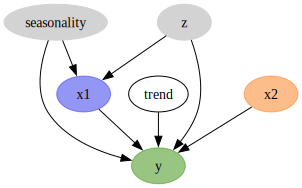

In [3]:
# https://graphviz.org/Gallery/neato/transparency.html
# https://github.com/arviz-devs/arviz/blob/main/arviz/plots/styles/arviz-darkgrid.mplstyle
g = gr.Digraph()
g.node(name="seasonality", label="seasonality", color="lightgray", style="filled")
g.node(name="trend", label="trend")
g.node(name="z", label="z", color="lightgray", style="filled")
g.node(name="x1", label="x1", color="#2a2eec80", style="filled")
g.node(name="x2", label="x2", color="#fa7c1780", style="filled")
g.node(name="y", label="y", color="#328c0680", style="filled")
g.edge(tail_name="seasonality", head_name="x1")
g.edge(tail_name="z", head_name="x1")
g.edge(tail_name="x1", head_name="y")
g.edge(tail_name="seasonality", head_name="y")
g.edge(tail_name="trend", head_name="y")
g.edge(tail_name="z", head_name="y")
g.edge(tail_name="x2", head_name="y")
g  # noqa: B018

In [4]:
# date range
min_date = pd.to_datetime("2021-10-02")
max_date = pd.to_datetime("2024-03-30")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-SAT")}
)

n = data_df.shape[0]

data_df["dayofyear"] = data_df["date"].dt.dayofyear
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 3) - 1
data_df["cs"] = -np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.25)
data_df["seasonality"] = 0.3 * (data_df["cs"] + data_df["cc"])
data_df["z"] = 0.3 * rng.gamma(shape=1, scale=2 / 3, size=n)

Text(0.5, 0.98, 'Data Components')

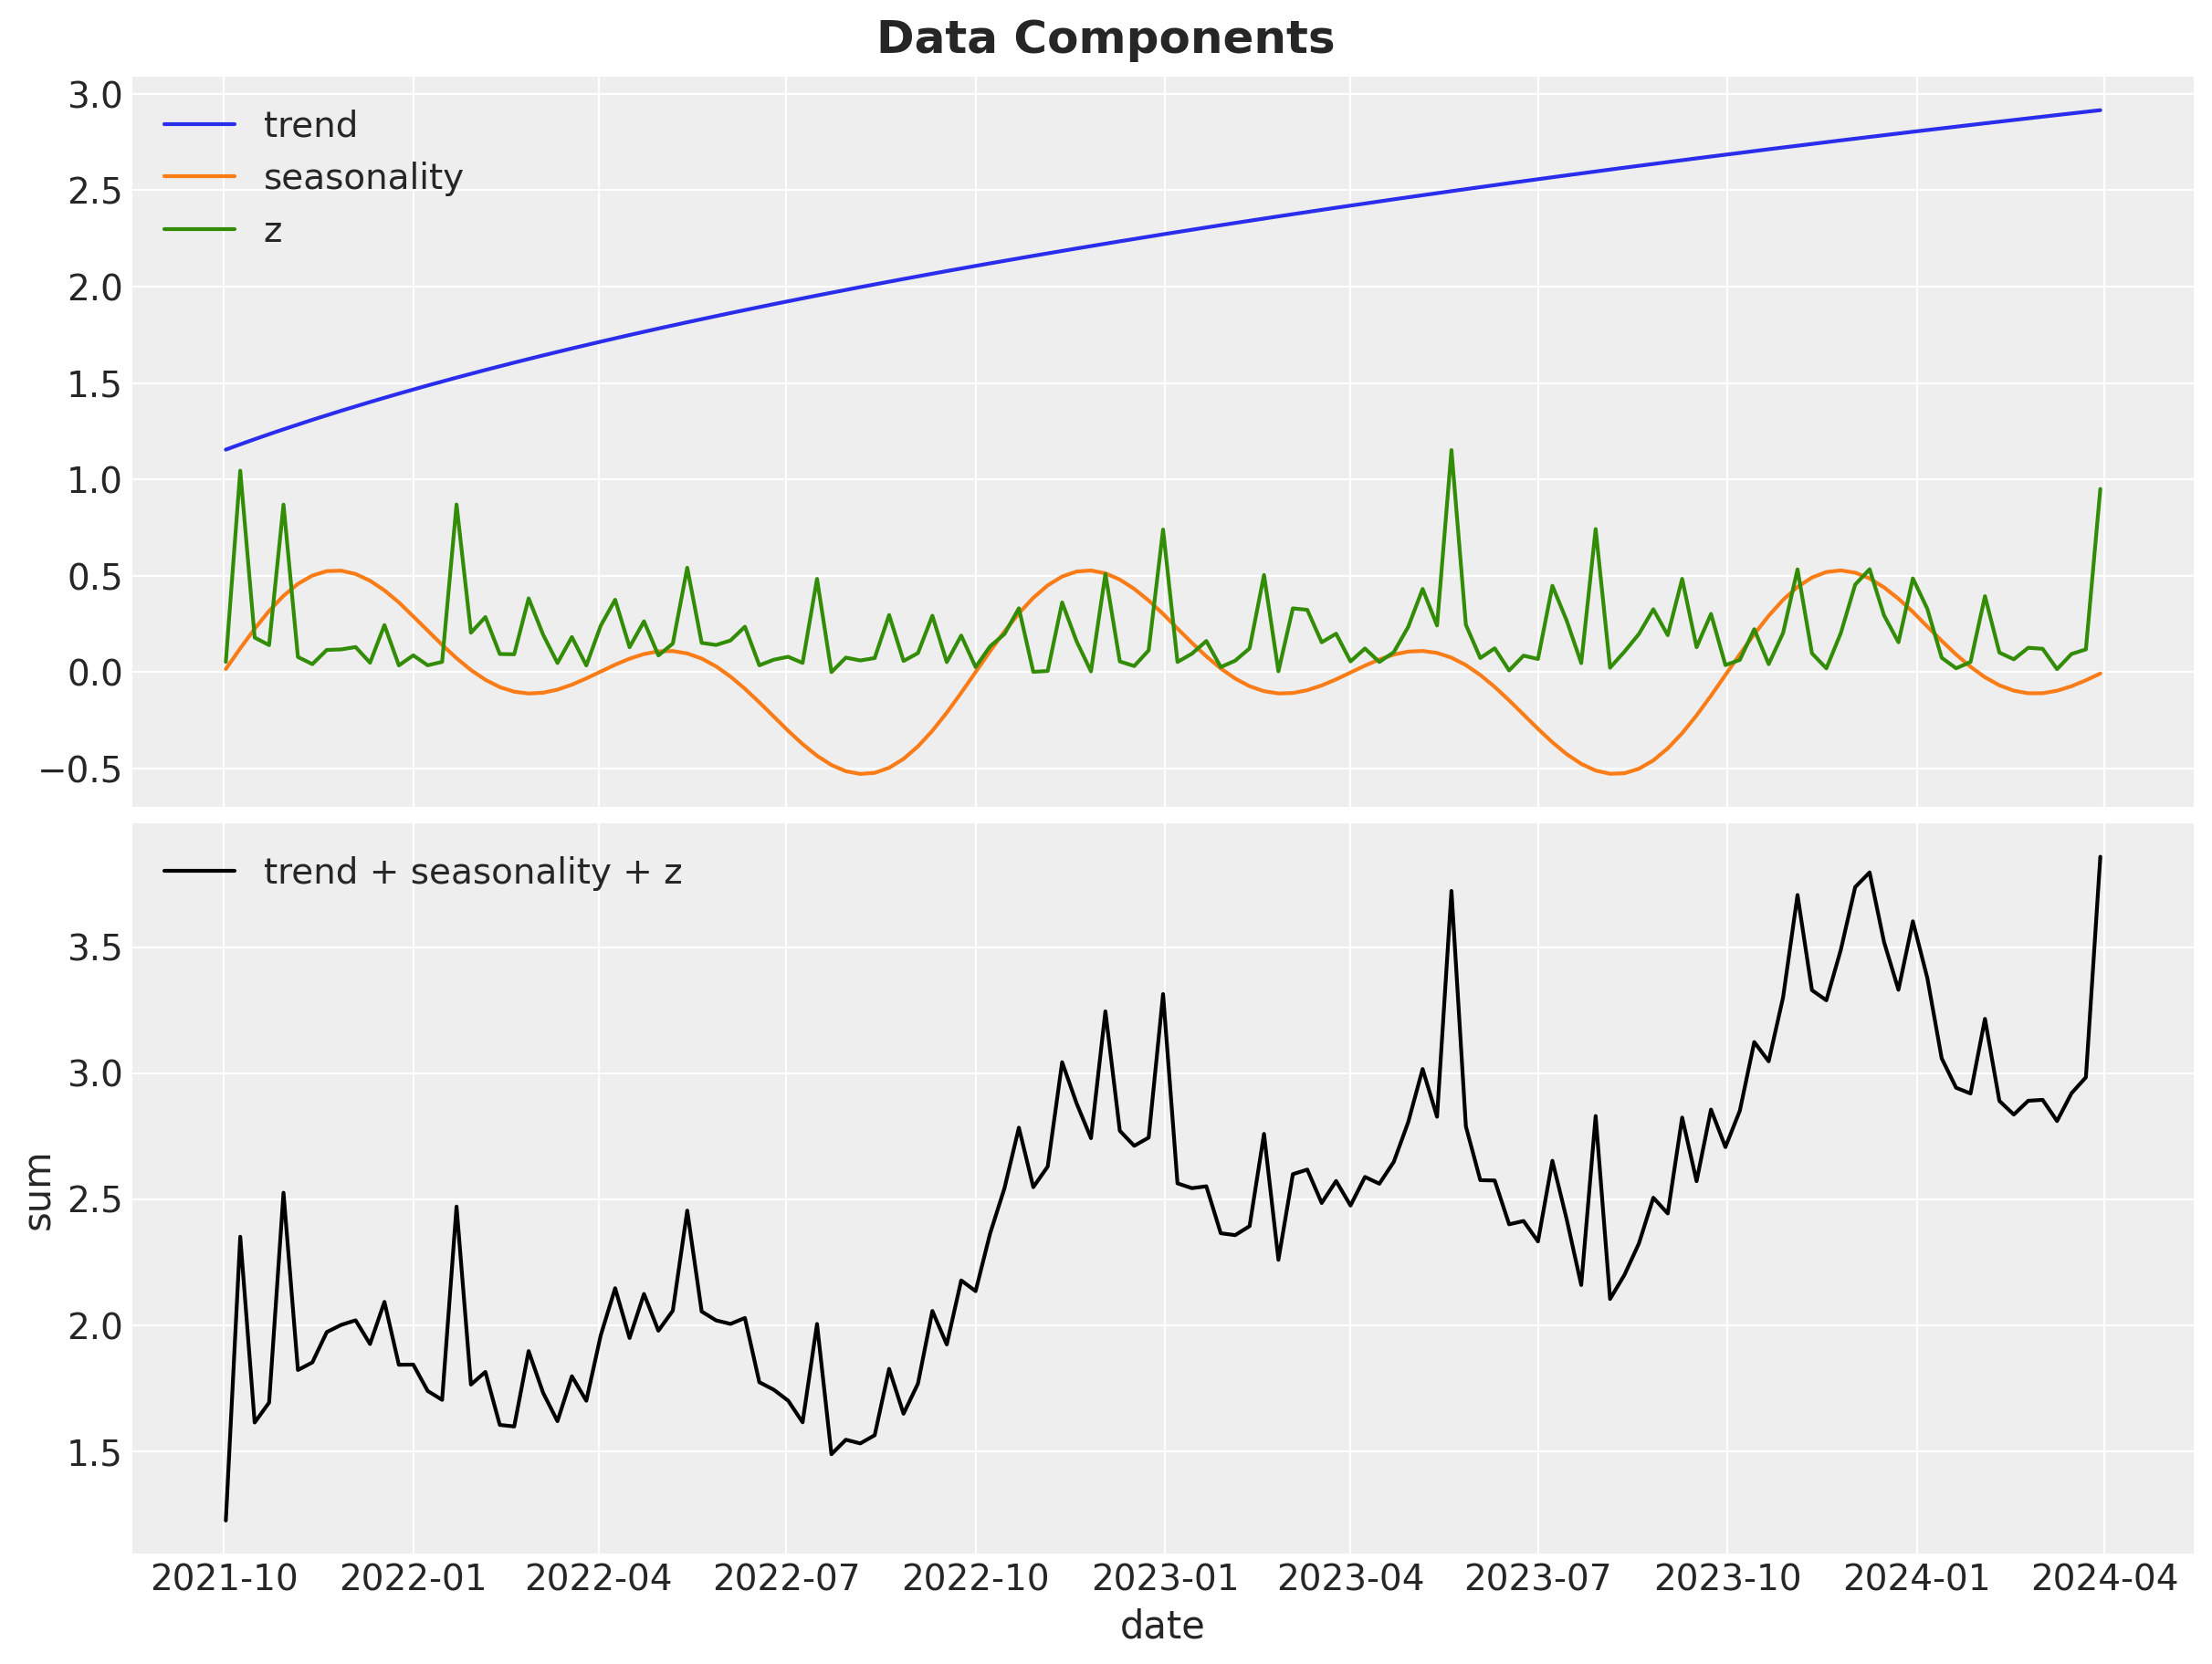

In [5]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 9),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", label="z", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z"),
    x="date",
    y="sum",
    color="black",
    label="trend + seasonality + z",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

In [6]:
data_df["x1"] = 1.2 * (
    0.5
    + 0.4 * data_df["seasonality"]
    + 0.6 * data_df["z"]
    + 0.1 * rng.poisson(lam=1 / 2, size=n)
)

data_df["x2"] = 0.3 * rng.gamma(shape=1, scale=1, size=n)

data_df["epsilon"] = rng.normal(loc=0, scale=0.1, size=n)

Text(0.5, 0.98, 'Data Components')

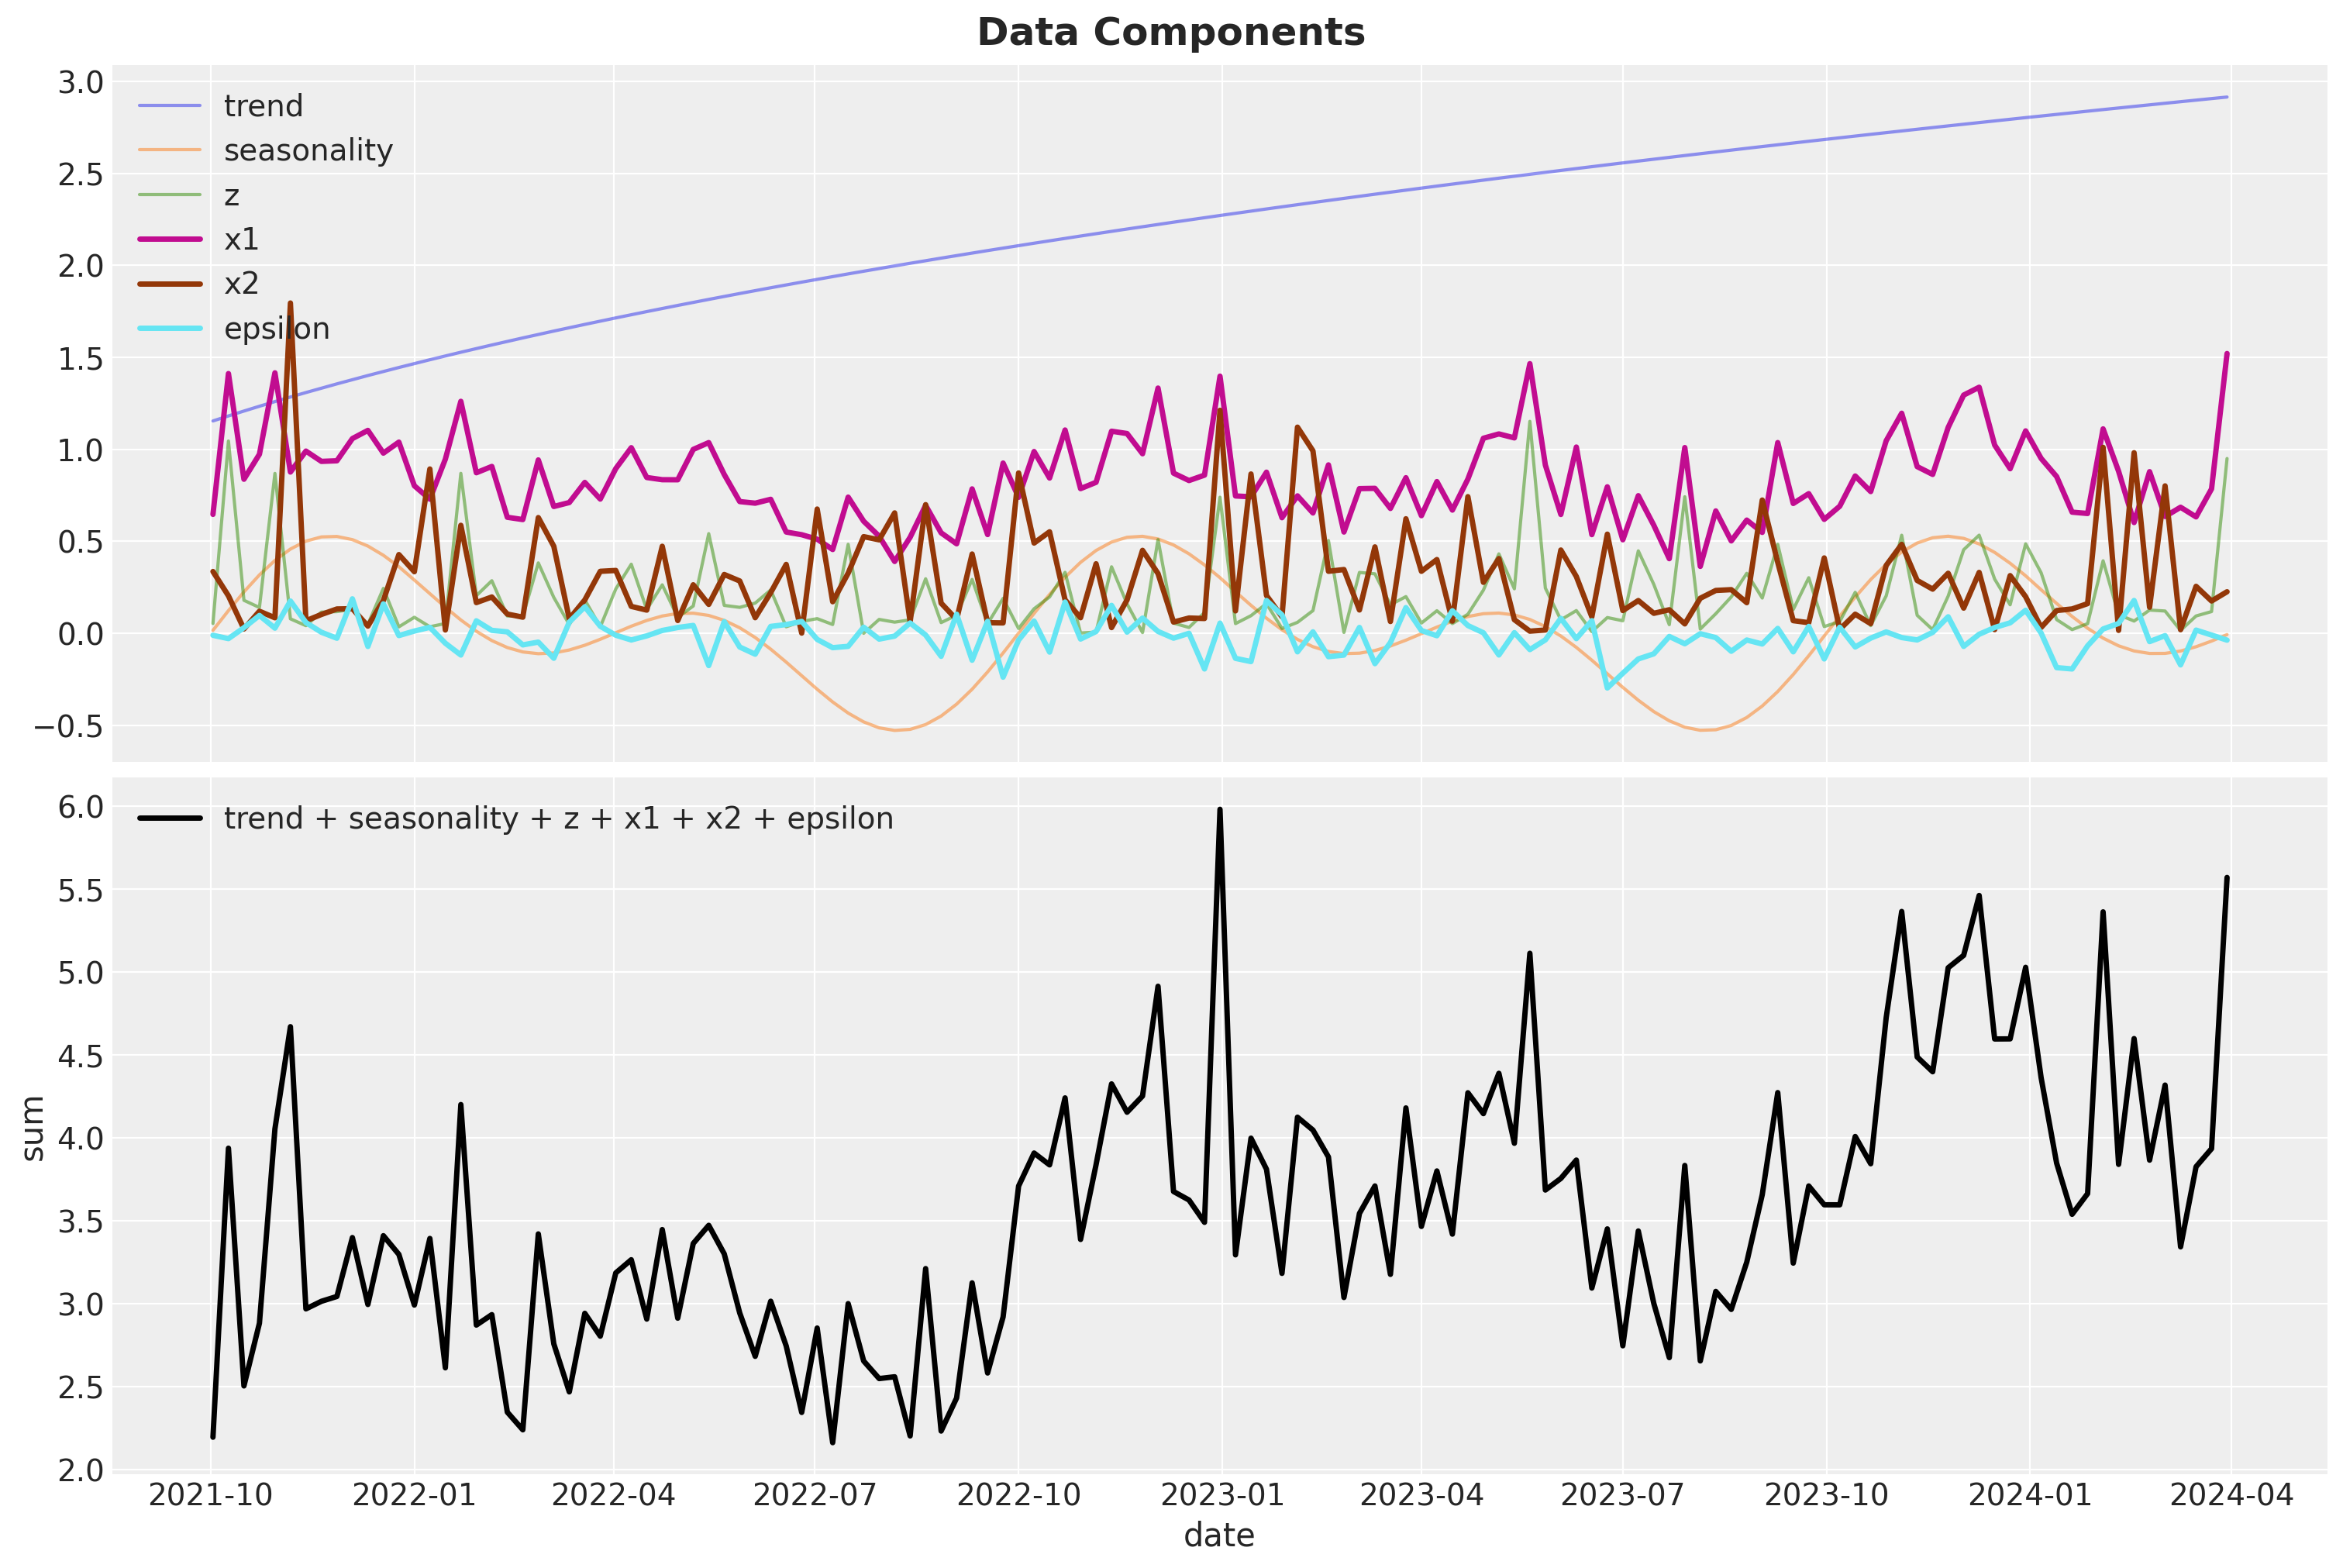

In [7]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", alpha=0.5, label="z", ax=ax[0])
sns.lineplot(
    data=data_df, x="date", y="x1", color="C3", linewidth=2.5, label="x1", ax=ax[0]
)
sns.lineplot(
    data=data_df, x="date", y="x2", color="C4", linewidth=2.5, label="x2", ax=ax[0]
)
sns.lineplot(
    data=data_df,
    x="date",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df.eval("sum = trend + seasonality + z + x1 + x2 + epsilon"),
    x="date",
    y="sum",
    color="black",
    linewidth=2.5,
    label="trend + seasonality + z + x1 + x2 + epsilon",
    ax=ax[1],
)
ax[1].legend(loc="upper left")

fig.suptitle(t="Data Components", fontsize=18, fontweight="bold")

In [ ]:
def geometric_adstock(x, alpha, l_max, normalize):
    """Vectorized geometric adstock transformation."""
    cycles = [
        pt.concatenate(tensor_list=[pt.zeros(shape=x.shape)[:i], x[: x.shape[0] - i]])
        for i in range(l_max)
    ]
    x_cycle = pt.stack(cycles)
    x_cycle = pt.transpose(x=x_cycle, axes=[1, 2, 0])
    w = pt.as_tensor_variable([pt.power(alpha, i) for i in range(l_max)])
    w = pt.transpose(w)[None, ...]
    w = w / pt.sum(w, axis=2, keepdims=True) if normalize else w
    return pt.sum(pt.mul(x_cycle, w), axis=2)


def logistic_saturation(x, lam):
    """Logistic saturation transformation."""
    return (1 - pt.exp(-lam * x)) / (1 + pt.exp(-lam * x))

In [9]:
# apply geometric adstock transformation
alpha1 = 0.3
alpha2 = 0.5

alpha = np.array([alpha1, alpha2])

data_df[["x1_adstock", "x2_adstock"]] = geometric_adstock(
    x=data_df[["x1", "x2"]], alpha=alpha, l_max=8, normalize=True
).eval()

Text(0.5, 0.98, 'Adstock Transformation')

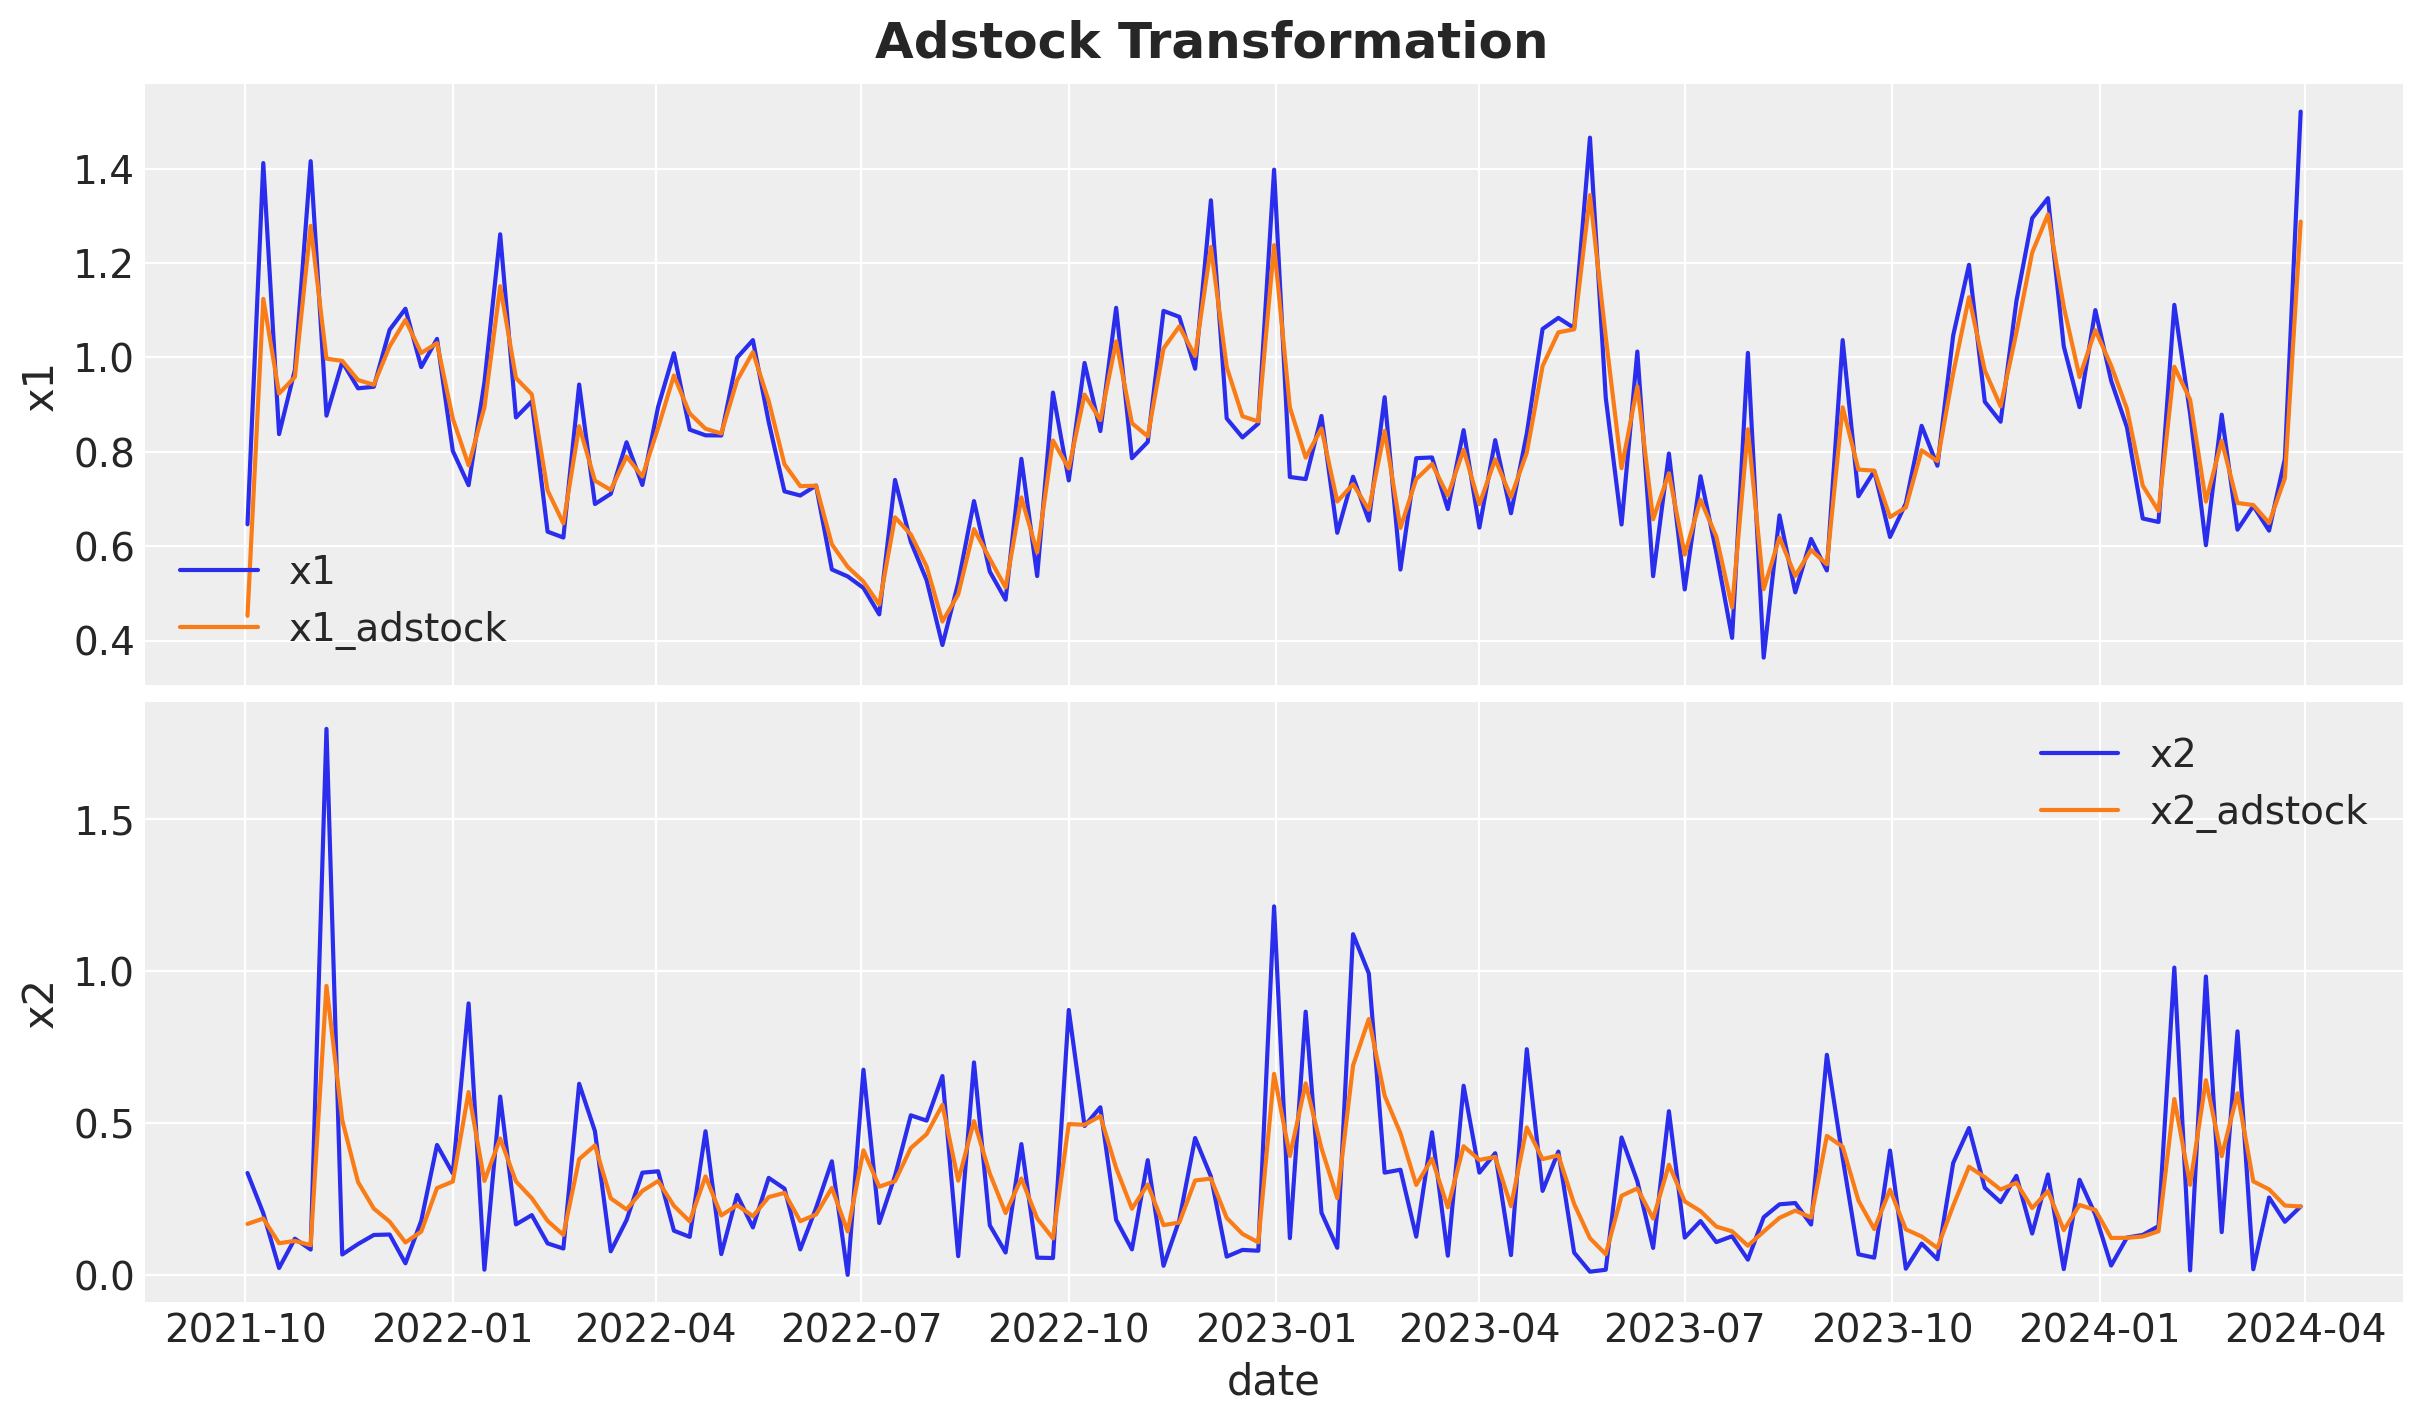

In [10]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=data_df, color="C0", label="x1", ax=ax[0])
sns.lineplot(
    x="date",
    y="x1_adstock",
    data=data_df,
    color="C1",
    label="x1_adstock",
    ax=ax[0],
)
sns.lineplot(x="date", y="x2", data=data_df, color="C0", label="x2", ax=ax[1])
sns.lineplot(
    x="date",
    y="x2_adstock",
    data=data_df,
    color="C1",
    label="x2_adstock",
    ax=ax[1],
)

fig.suptitle("Adstock Transformation", fontsize=18, fontweight="bold")

In [11]:
# apply saturation transformation
lam1 = 1.0
lam2 = 2.5

lam = np.array([lam1, lam2])

data_df[["x1_adstock_saturated", "x2_adstock_saturated"]] = logistic_saturation(
    x=data_df[["x1_adstock", "x2_adstock"]], lam=lam
).eval()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_13958/149485743.py:10: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


Text(0.5, 0.98, 'Media Costs Data - Transformed')

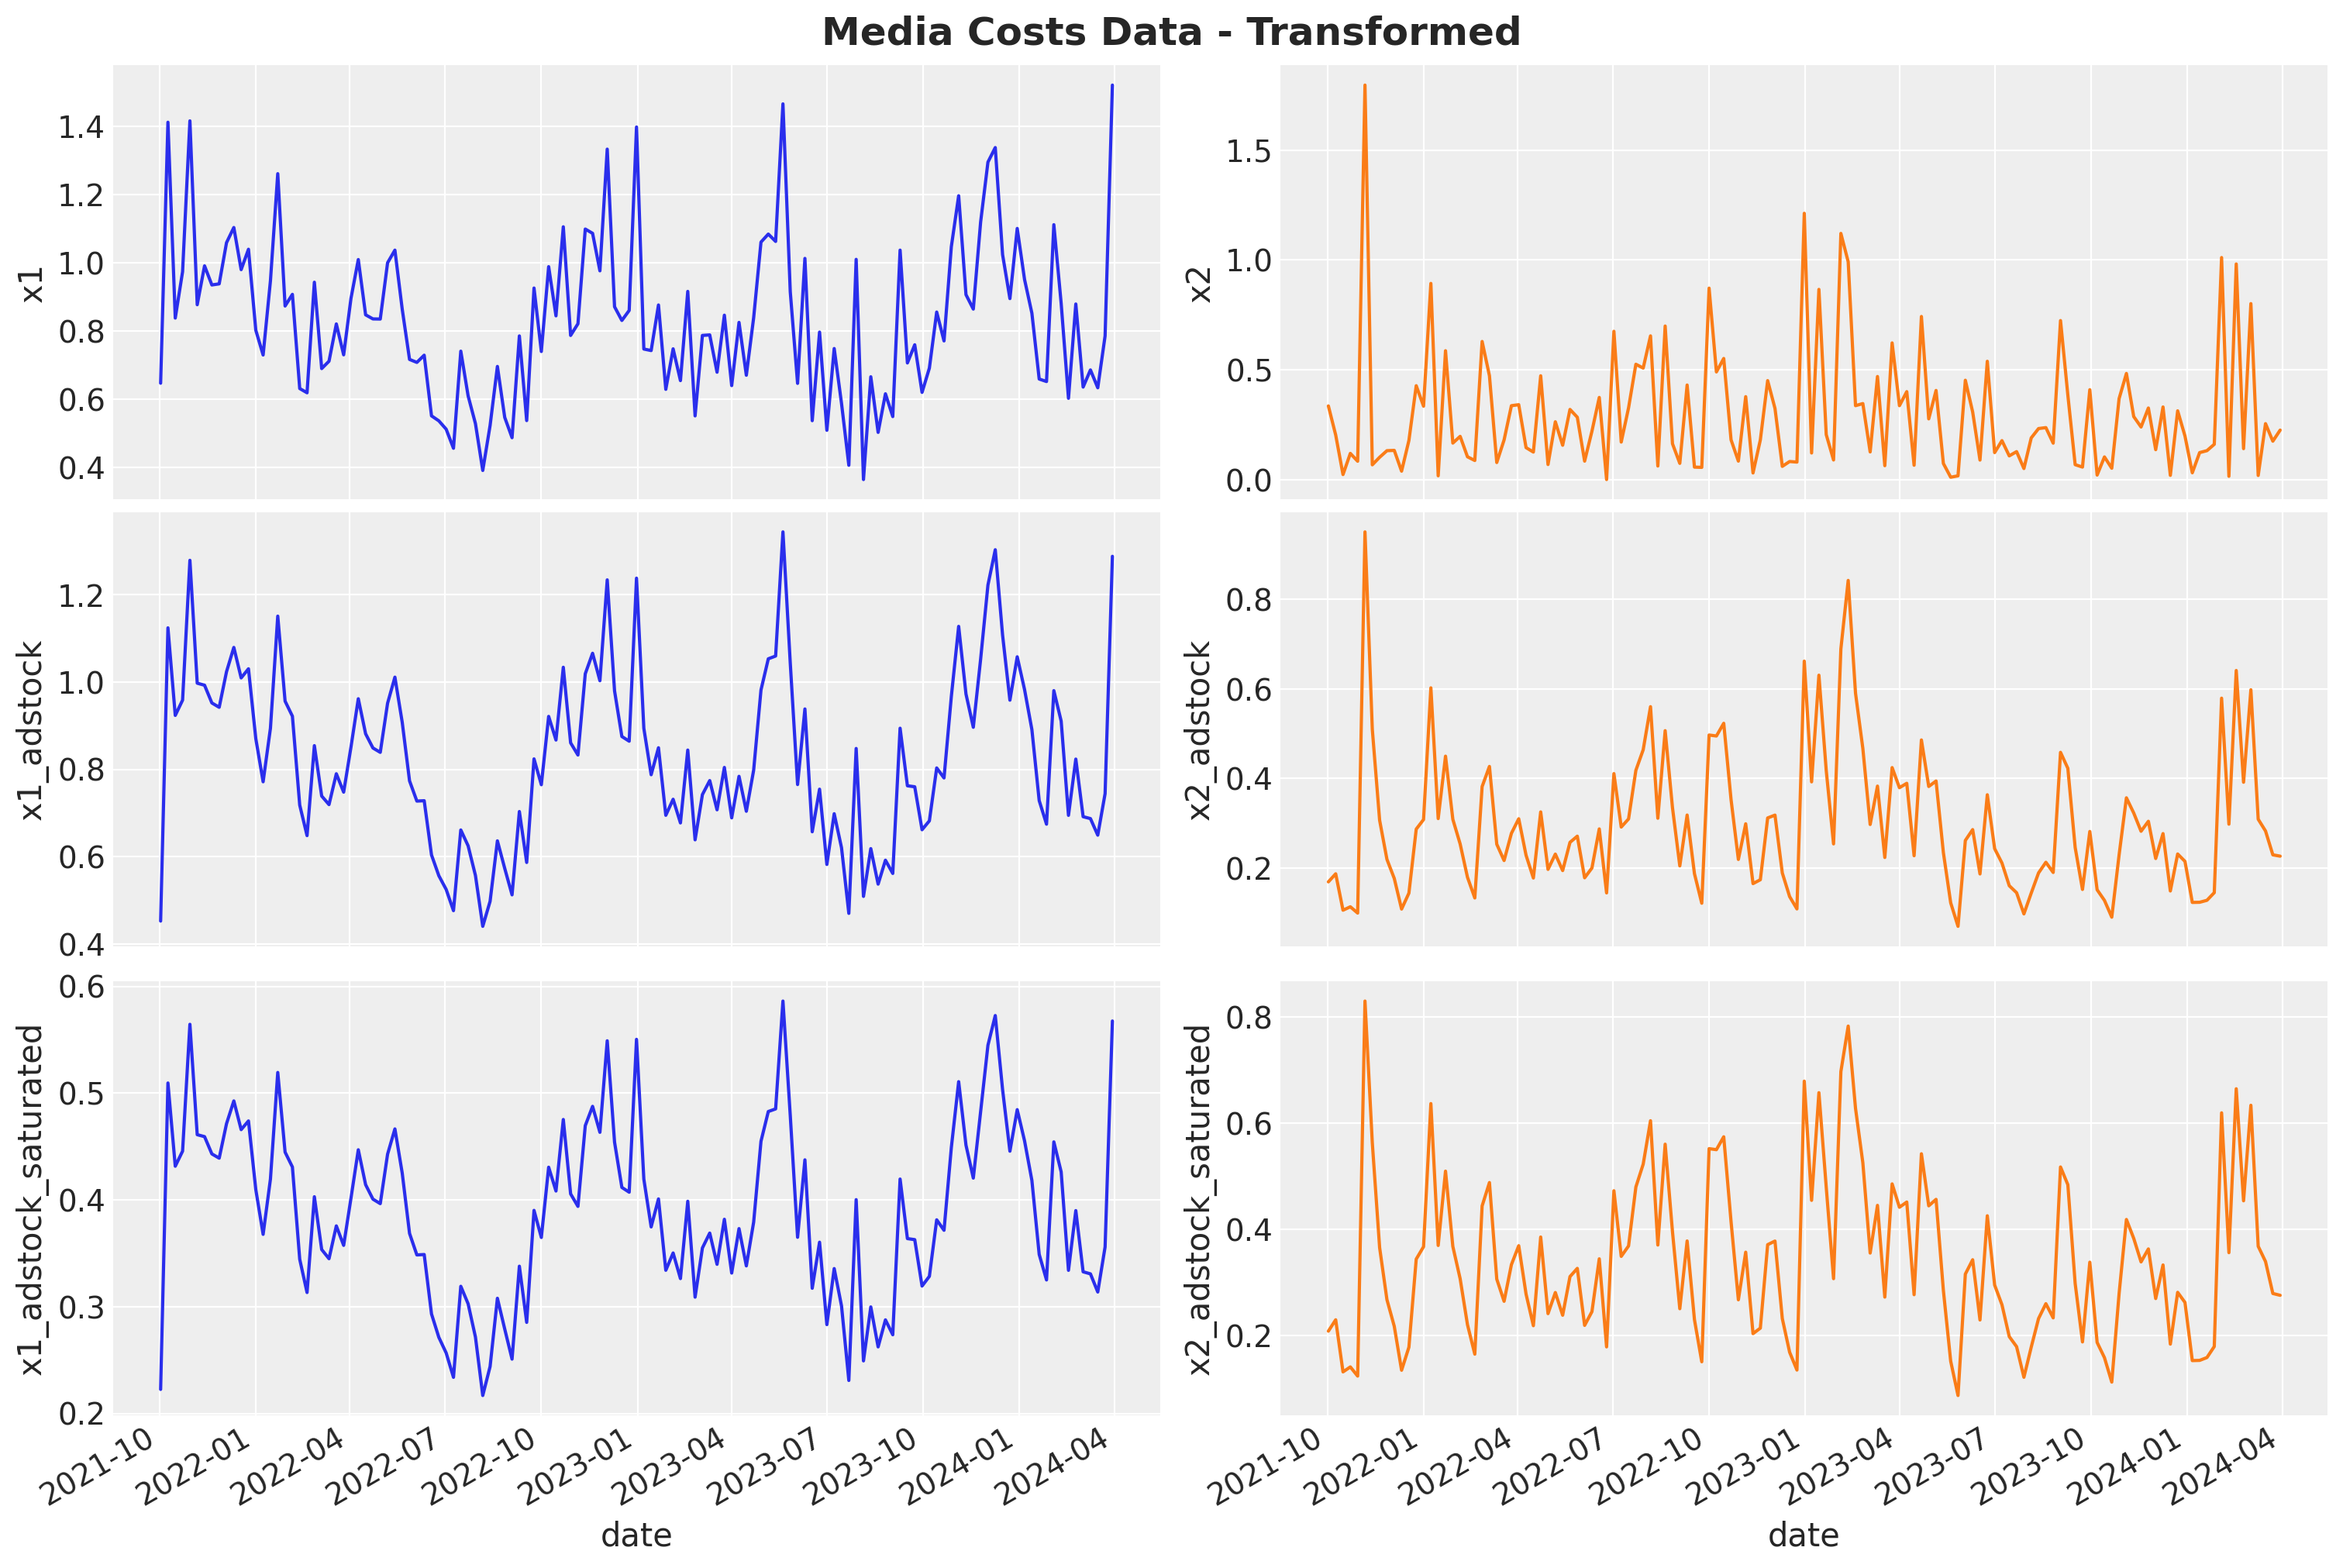

In [12]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(15, 10), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="x1", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date", y="x2", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date", y="x1_adstock", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date", y="x2_adstock", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date", y="x1_adstock_saturated", data=data_df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date", y="x2_adstock_saturated", data=data_df, color="C1", ax=ax[2, 1])
fig.autofmt_xdate()
fig.suptitle("Media Costs Data - Transformed", fontsize=18, fontweight="bold")

In [13]:
beta1 = 2.0
beta2 = 1.5

data_df = data_df.eval(
    f"""
    x1_effect = {beta1} * x1_adstock_saturated
    x2_effect = {beta2} * x2_adstock_saturated
    y = 100 * (trend + seasonality + z + x1_effect + x2_effect + epsilon)
    """
)

Text(0.5, 0.98, 'Data Generating Process')

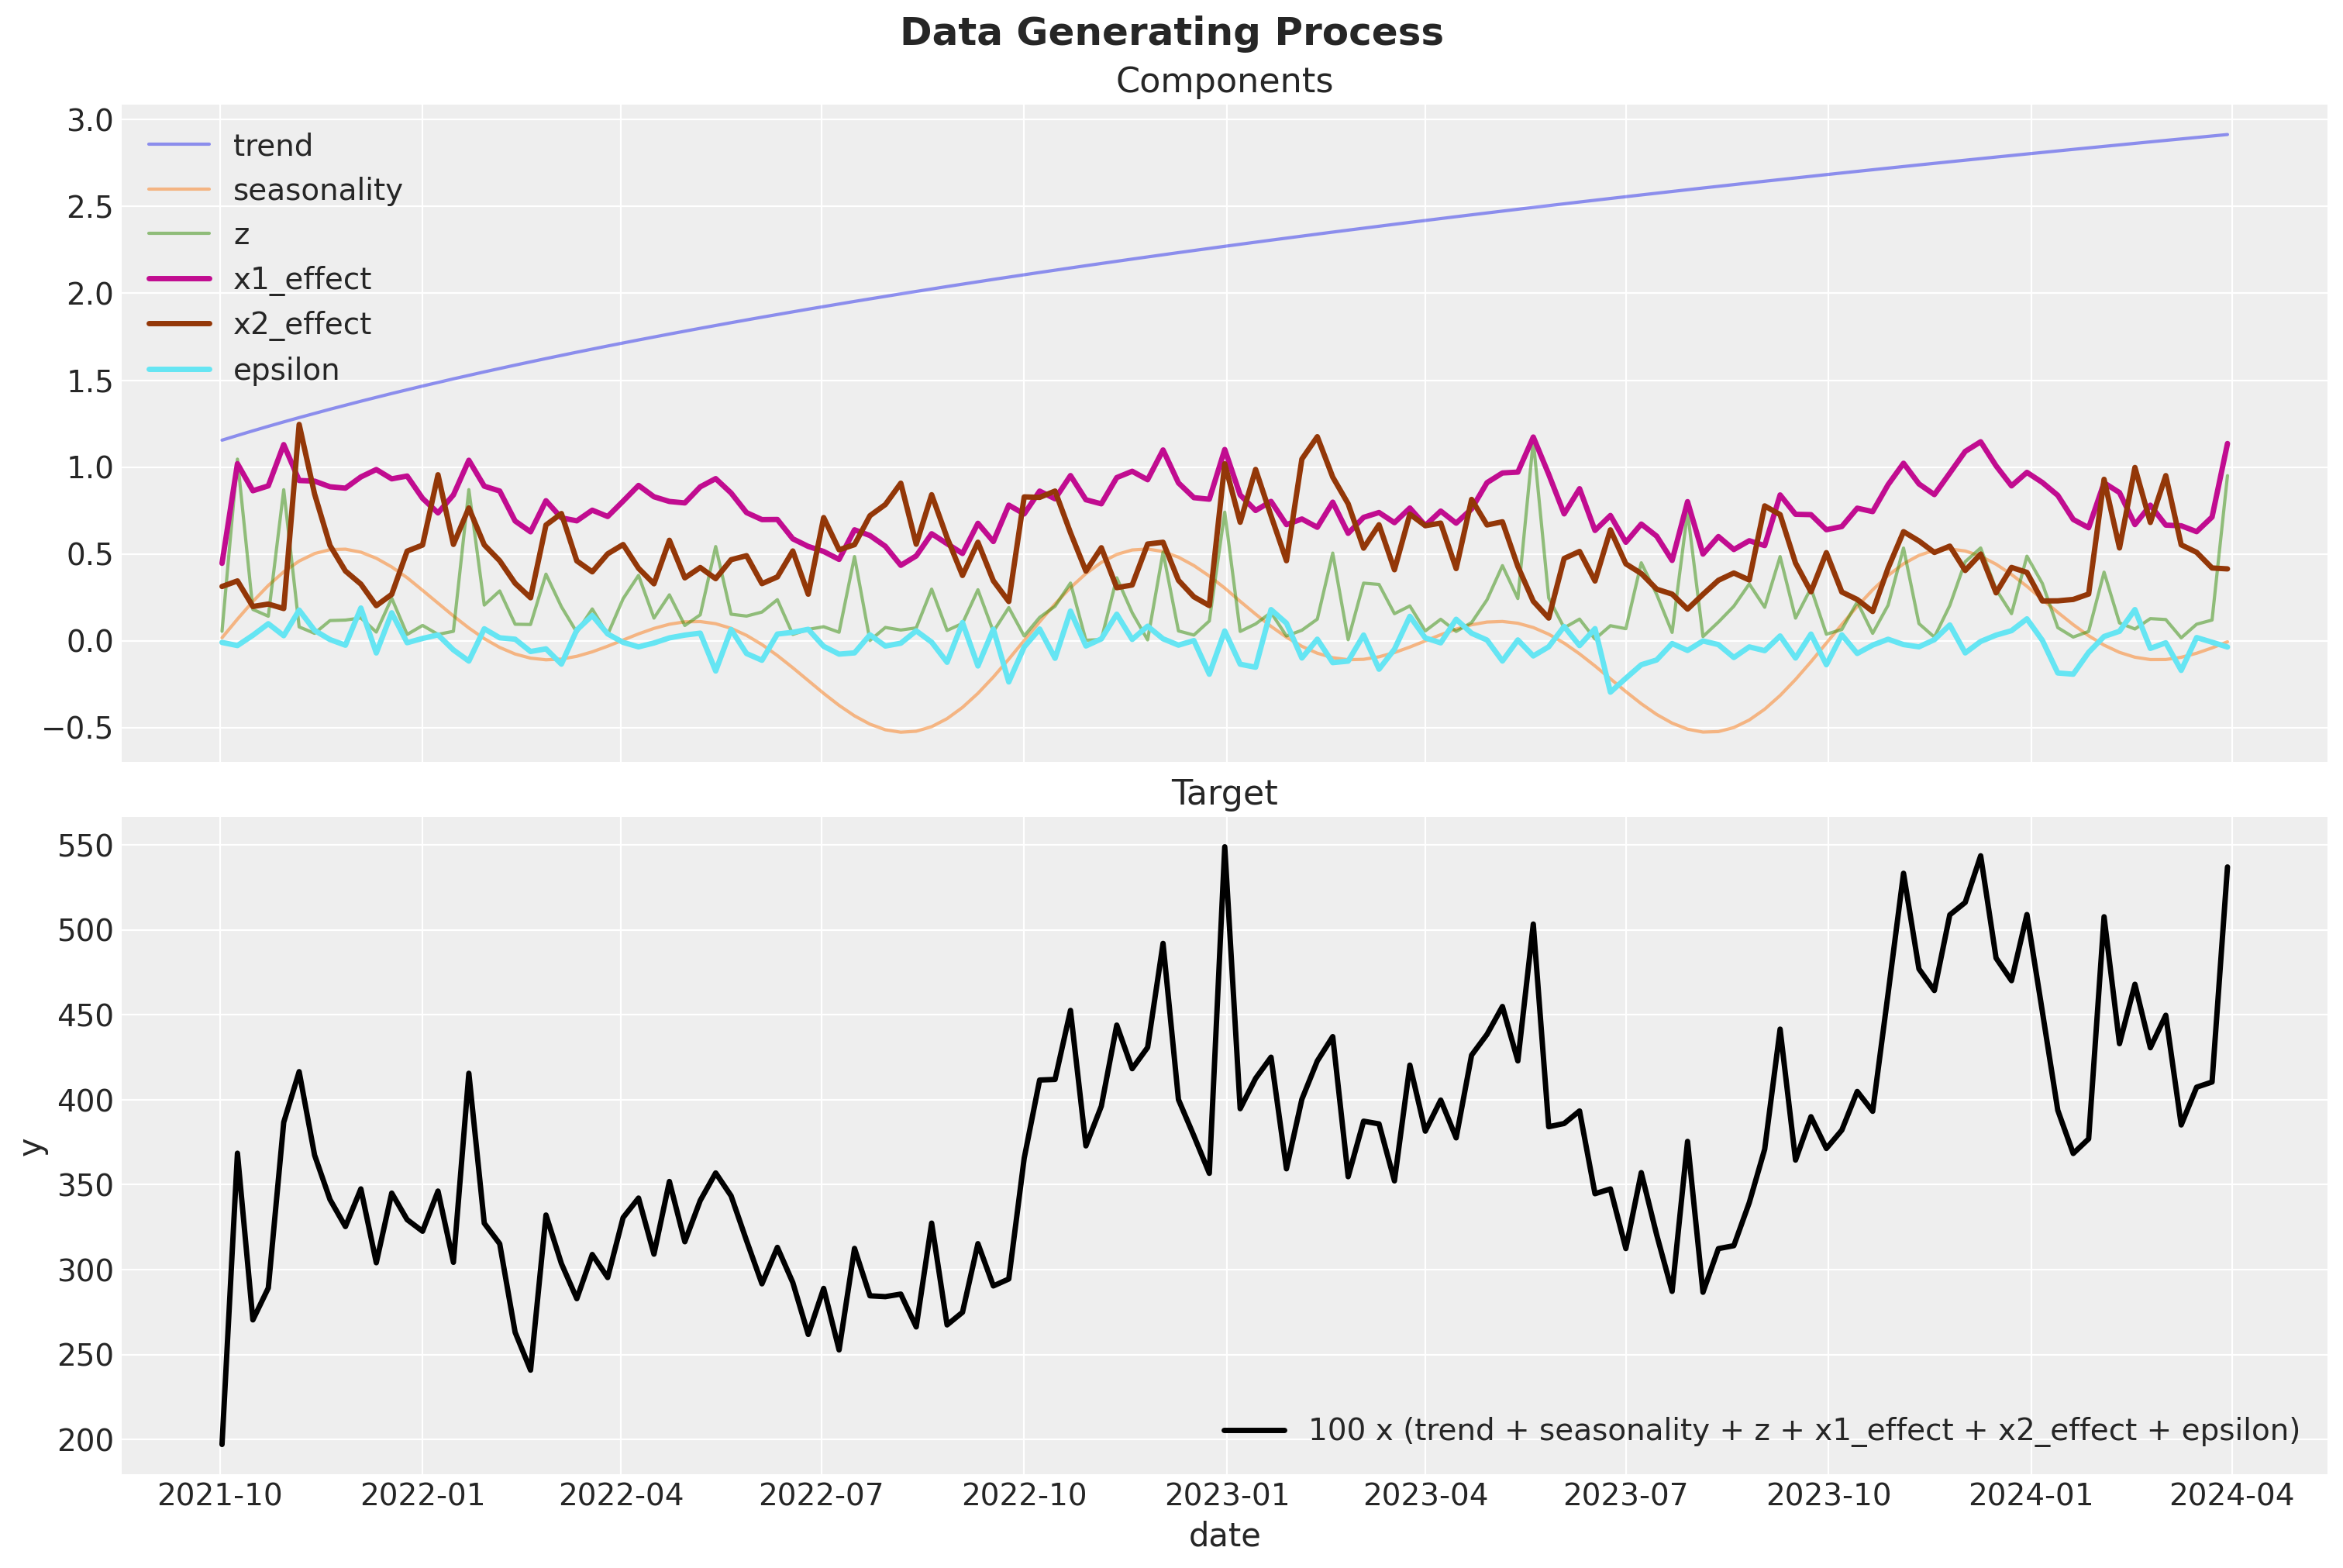

In [14]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(15, 10),
    sharex=True,
    sharey=False,
    layout="constrained",
)
sns.lineplot(
    data=data_df,
    x="date",
    y="trend",
    color="C0",
    alpha=0.5,
    label="trend",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="seasonality",
    color="C1",
    alpha=0.5,
    label="seasonality",
    ax=ax[0],
)
sns.lineplot(data=data_df, x="date", y="z", color="C2", alpha=0.5, label="z", ax=ax[0])
sns.lineplot(
    data=data_df,
    x="date",
    y="x1_effect",
    color="C3",
    linewidth=2.5,
    label="x1_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="x2_effect",
    color="C4",
    linewidth=2.5,
    label="x2_effect",
    ax=ax[0],
)
sns.lineplot(
    data=data_df,
    x="date",
    y="epsilon",
    color="C5",
    linewidth=2.5,
    label="epsilon",
    ax=ax[0],
)
ax[0].legend(loc="upper left")
ax[0].set(title="Components", xlabel="date", ylabel=None)

sns.lineplot(
    data=data_df,
    x="date",
    y="y",
    color="black",
    linewidth=2.5,
    label="100 x (trend + seasonality + z + x1_effect + x2_effect + epsilon)",
    ax=ax[1],
)
ax[1].legend(loc="lower right")
ax[1].set(title="Target")

fig.suptitle(t="Data Generating Process", fontsize=18, fontweight="bold")

In [15]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  131 non-null    datetime64[ns]
 1   dayofyear             131 non-null    int32         
 2   trend                 131 non-null    float64       
 3   cs                    131 non-null    float64       
 4   cc                    131 non-null    float64       
 5   seasonality           131 non-null    float64       
 6   z                     131 non-null    float64       
 7   x1                    131 non-null    float64       
 8   x2                    131 non-null    float64       
 9   epsilon               131 non-null    float64       
 10  x1_adstock            131 non-null    float64       
 11  x2_adstock            131 non-null    float64       
 12  x1_adstock_saturated  131 non-null    float64       
 13  x2_adstock_saturated

### Data Preparation

In [16]:
columns_to_keep = [
    "date",
    "dayofyear",
    "z",
    "x1",
    "x2",
    "y",
]

model_df = data_df[columns_to_keep]

model_df.head()

date  dayofyear         z        x1        x2           y
0 2021-10-02        275  0.053693  0.646554  0.336188  197.094468
1 2021-10-09        282  1.045243  1.411917  0.203931  368.498137
2 2021-10-16        289  0.179703  0.837610  0.024026  270.395147
3 2021-10-23        296  0.140496  0.973612  0.120257  289.185476
4 2021-10-30        303  0.869155  1.415985  0.084630  386.717105

In [17]:
date = model_df["date"]

index_scaler = MaxAbsScaler()
index_scaled = index_scaler.fit_transform(model_df.reset_index(drop=False)[["index"]])

target = "y"
target_scaler = MaxAbsScaler()
target_scaled = target_scaler.fit_transform(model_df[[target]])

channels = ["x1", "x2"]
channels_scaler = MaxAbsScaler()
channels_scaled = channels_scaler.fit_transform(model_df[channels])

controls = ["z"]
controls_scaler = MaxAbsScaler()
controls_scaled = controls_scaler.fit_transform(model_df[controls])

In [18]:
n_order = 5
periods = model_df["dayofyear"] / 365.25
fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * periods * order)
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
)

## Model Parametrization 1

In [19]:
coords = {"date": date, "channel": channels, "fourier_mode": np.arange(2 * n_order)}

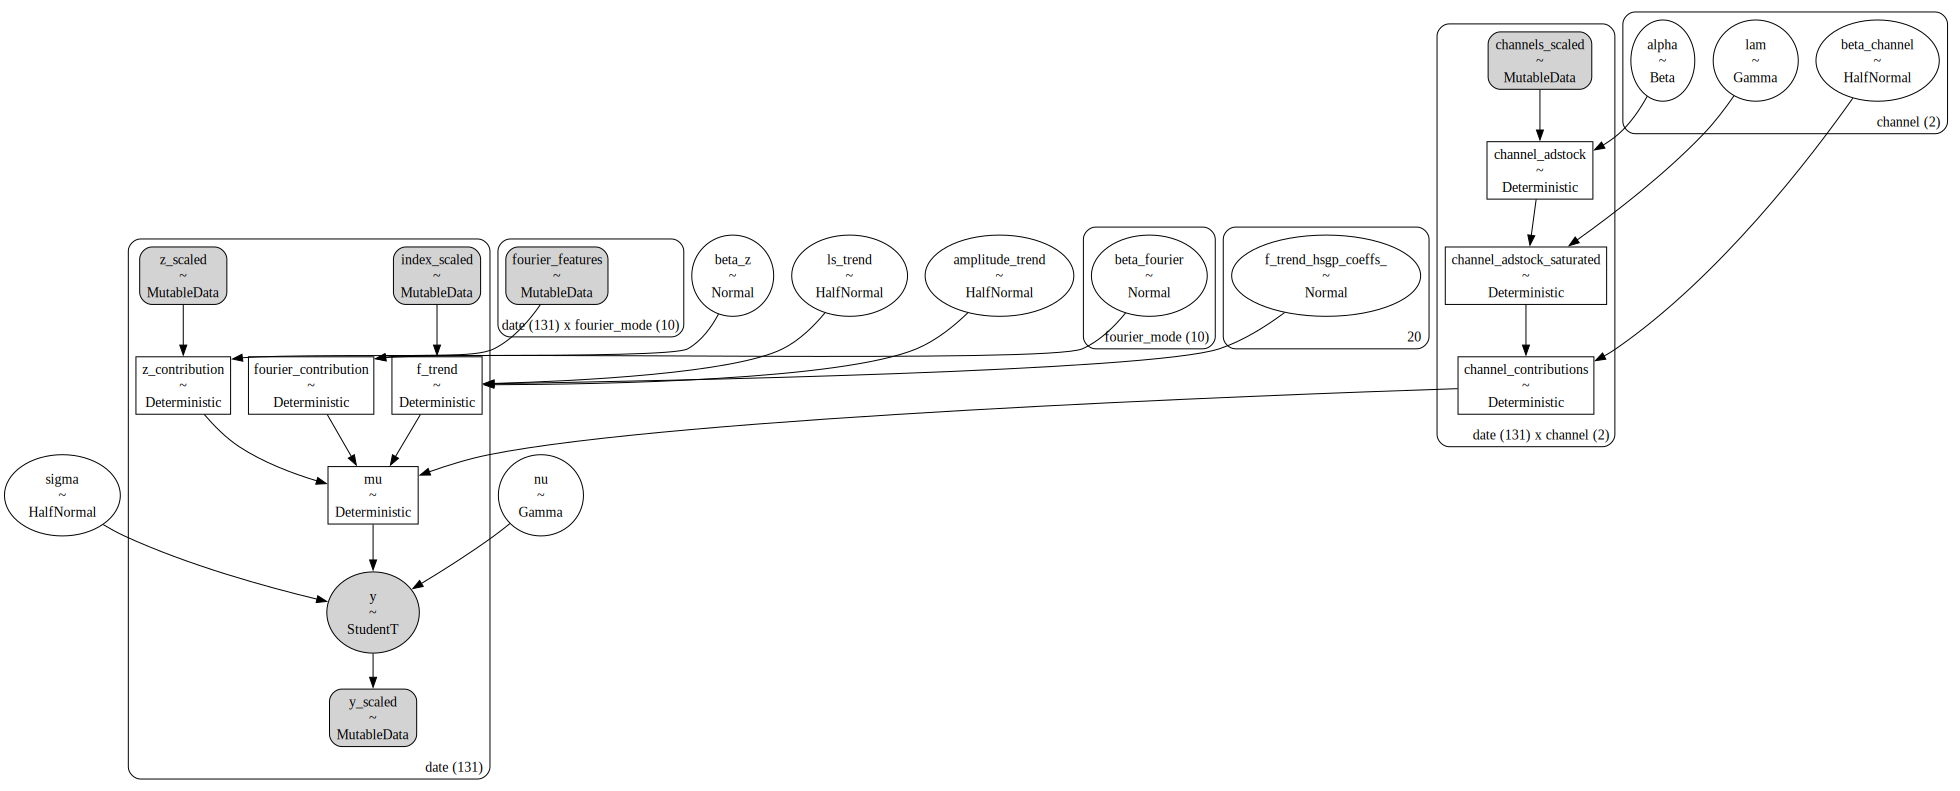

In [61]:
with pm.Model(coords=coords) as model_1:
    # --- Data Containers ---

    index_scaled_data = pm.Data(
        name="index_scaled",
        value=index_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    channels_scaled_data = pm.Data(
        name="channels_scaled",
        value=channels_scaled,
        mutable=True,
        dims=("date", "channel"),
    )

    z_scaled_data = pm.Data(
        name="z_scaled",
        value=controls_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    fourier_features_data = pm.Data(
        name="fourier_features",
        value=fourier_features,
        mutable=True,
        dims=("date", "fourier_mode"),
    )

    y_scaled_data = pm.Data(
        name="y_scaled",
        value=target_scaled.to_numpy().flatten(),
        mutable=True,
        dims="date",
    )

    # --- Priors ---

    amplitude_trend = pm.HalfNormal(name="amplitude_trend", sigma=1)
    ls_trend = pm.HalfNormal(name="ls_trend", sigma=0.1)

    alpha = pm.Beta(name="alpha", alpha=1, beta=3, dims="channel")
    lam = pm.Gamma(name="lam", alpha=2, beta=4, dims="channel")
    beta_channel = pm.HalfNormal(name="beta_channel", sigma=1, dims="channel")
    beta_z = pm.Normal(name="beta_z", mu=0, sigma=1)
    beta_fourier = pm.Normal(name="beta_fourier", mu=0, sigma=1, dims="fourier_mode")

    sigma = pm.HalfNormal(name="sigma", sigma=2)
    nu = pm.Gamma(name="nu", alpha=25, beta=2)

    # --- Parametrization ---

    cov_trend = amplitude_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=ls_trend)
    gp_trend = pm.gp.HSGP(m=[20], c=1.5, cov_func=cov_trend)
    f_trend = gp_trend.prior(name="f_trend", X=index_scaled_data[:, None], dims="date")

    channel_adstock = pm.Deterministic(
        name="channel_adstock",
        var=geometric_adstock(
            x=channels_scaled_data,
            alpha=alpha,
            l_max=8,
            normalize=True,
        ),
        dims=("date", "channel"),
    )
    channel_adstock_saturated = pm.Deterministic(
        name="channel_adstock_saturated",
        var=logistic_saturation(x=channel_adstock, lam=lam),
        dims=("date", "channel"),
    )
    channel_contributions = pm.Deterministic(
        name="channel_contributions",
        var=channel_adstock_saturated * beta_channel,
        dims=("date", "channel"),
    )

    fourier_contribution = pm.Deterministic(
        name="fourier_contribution",
        var=pt.dot(fourier_features_data, beta_fourier),
        dims="date",
    )

    z_contribution = pm.Deterministic(
        name="z_contribution",
        var=z_scaled_data * beta_z,
        dims="date",
    )

    mu = pm.Deterministic(
        name="mu",
        var=f_trend
        + channel_contributions.sum(axis=-1)
        + z_contribution
        + fourier_contribution,
        dims="date",
    )

    # --- Likelihood ---
    y = pm.StudentT(
        name="y",
        nu=nu,
        mu=mu,
        sigma=sigma,
        observed=y_scaled_data,
        dims="date",
    )

pm.model_to_graphviz(model=model_1)

## Prior Predictive Checks

In [62]:
with model_1:
    prior_predictive_1 = pm.sample_prior_predictive(samples=2_000, random_seed=rng)

Sampling: [alpha, amplitude_trend, beta_channel, beta_fourier, beta_z, f_trend_hsgp_coeffs_, lam, ls_trend, nu, sigma, y]


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


Text(0.5, 1.0, 'Prior Predictive - Model 1')

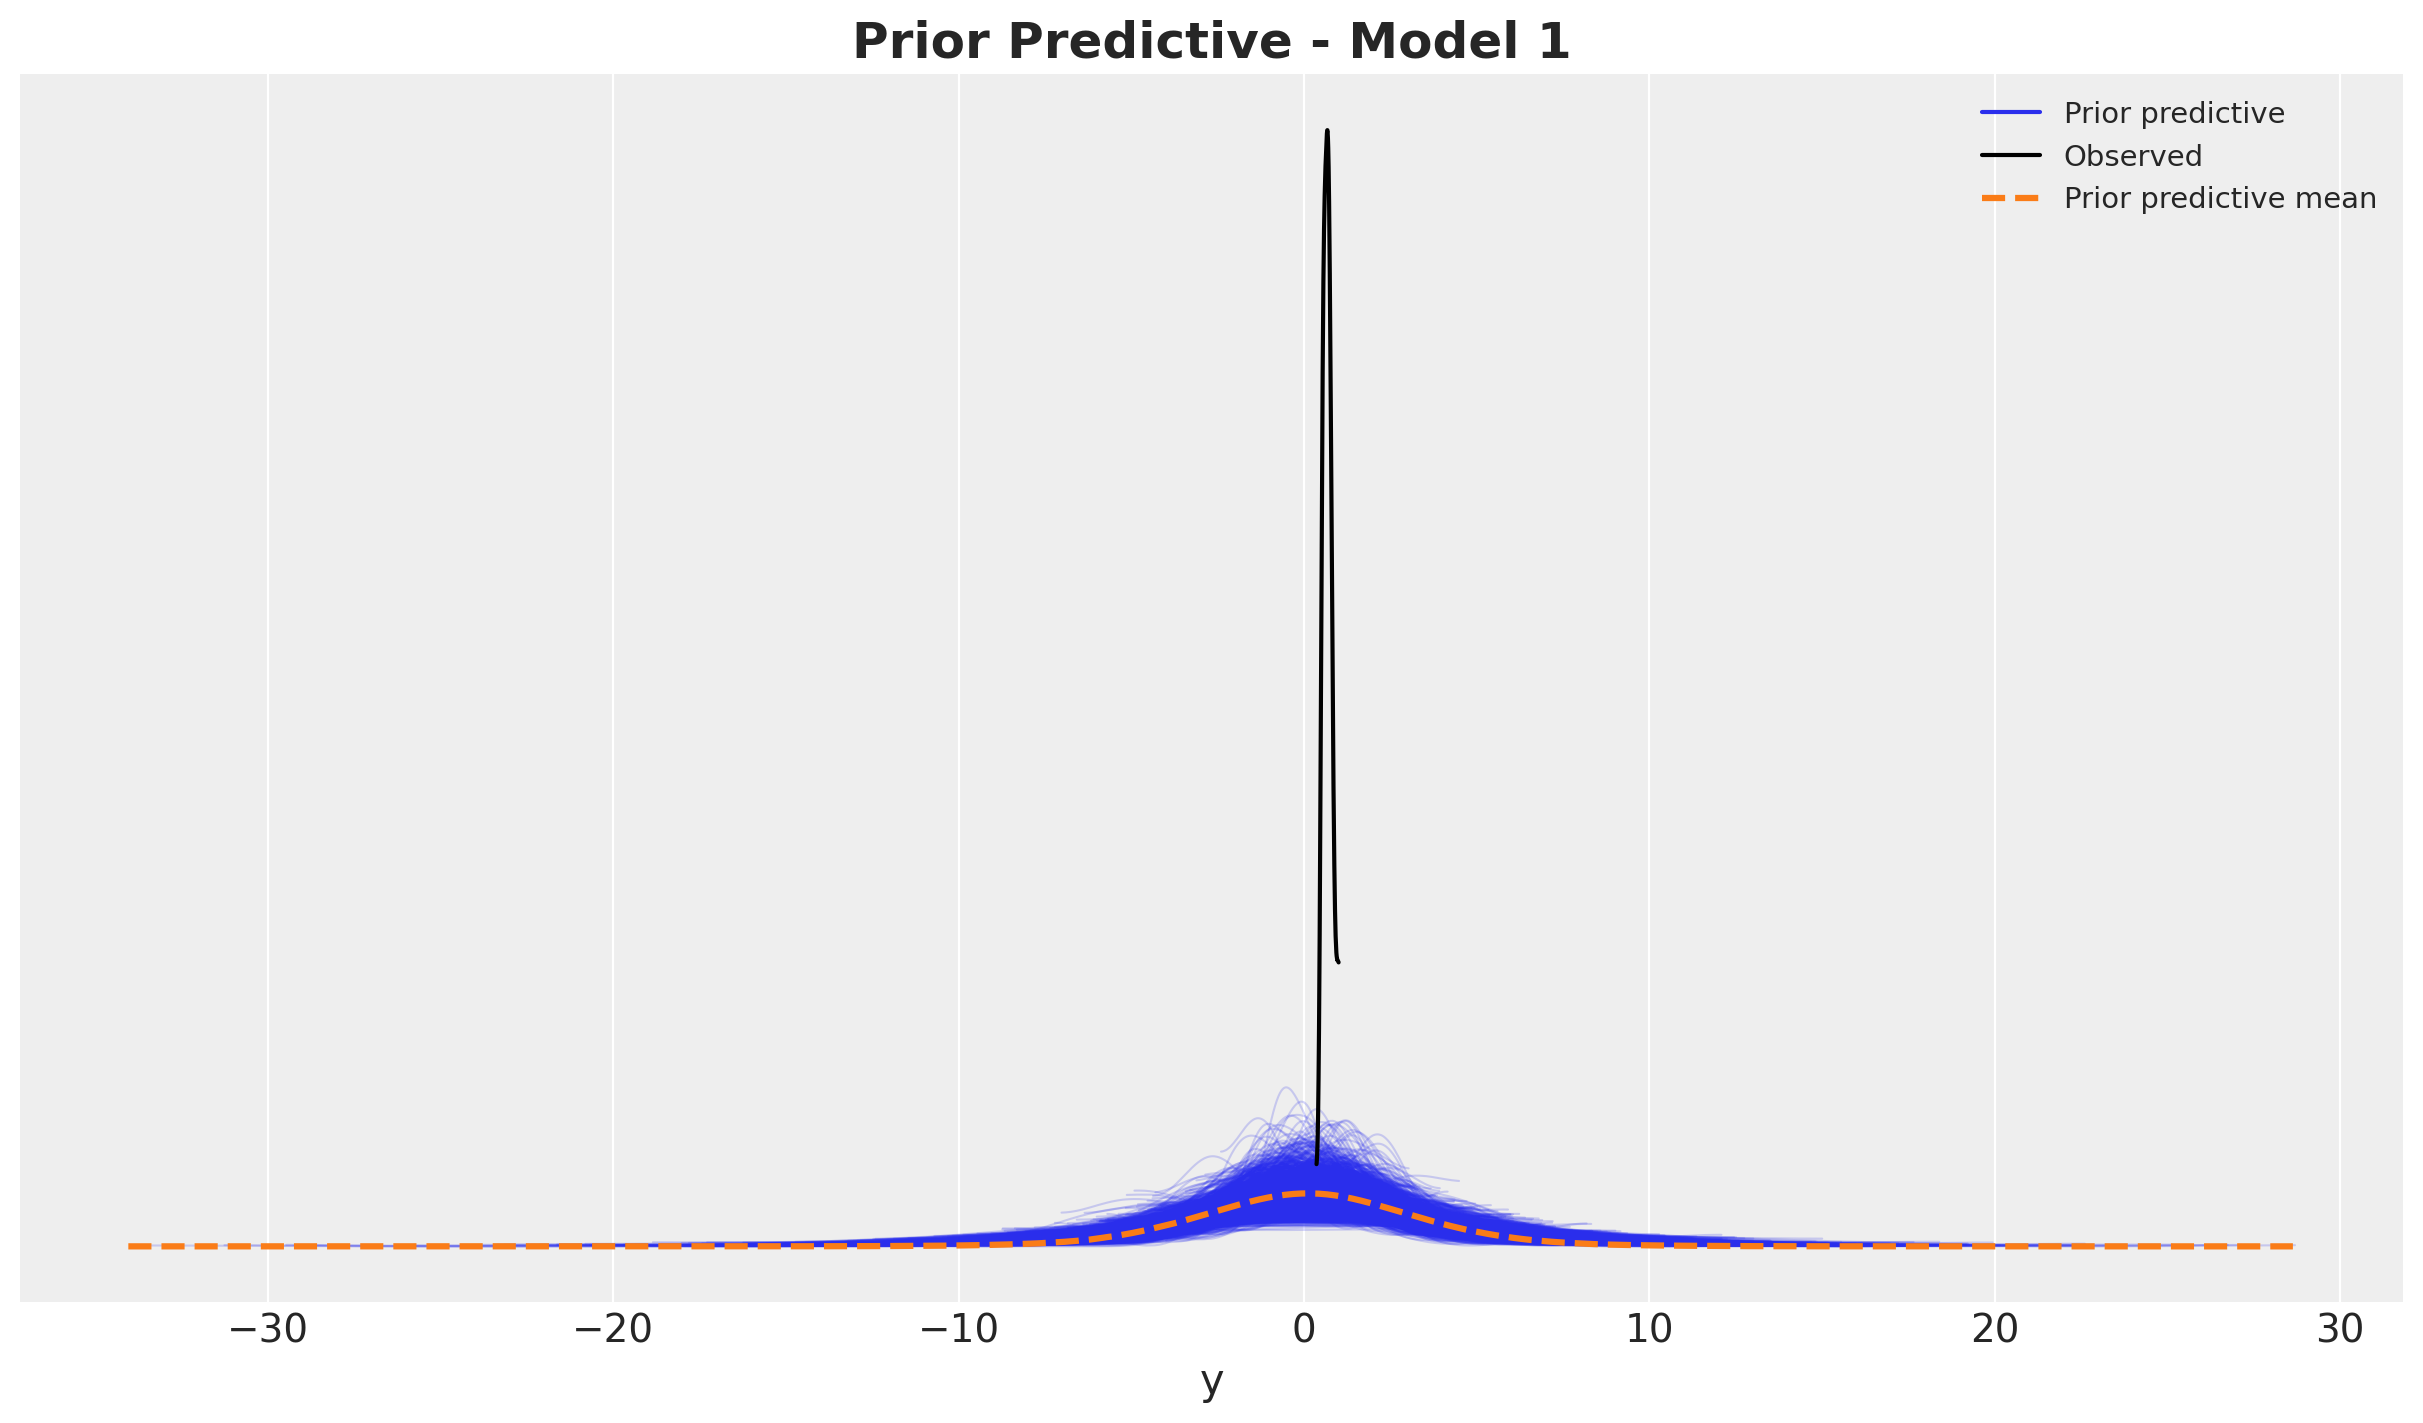

In [63]:
fig, ax = plt.subplots()
az.plot_ppc(data=prior_predictive_1, group="prior", kind="kde", ax=ax)
ax.set_title(label="Prior Predictive - Model 1", fontsize=18, fontweight="bold")

In [64]:
with model_1:
    idata_1 = pm.sample(
        target_accept=0.85,
        draws=2_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )
    posterior_predictive_1 = pm.sample_posterior_predictive(
        trace=idata_1, random_seed=rng
    )

Compiling...
Compilation time = 0:00:12.157581
Sampling...


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

Sampling time = 0:01:12.829495
Transforming variables...
Transformation time = 0:00:01.956632
Sampling: [y]


In [65]:
idata_1["sample_stats"]["diverging"].sum().item()

0

In [66]:
var_names = [
    "amplitude_trend",
    "ls_trend",
    "alpha",
    "lam",
    "beta_channel",
    "beta_z",
    "beta_fourier",
    "sigma",
    "nu",
]

az.summary(data=idata_1, var_names=var_names, round_to=3)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
amplitude_trend    0.252  0.222   0.026    0.659      0.005    0.003   
ls_trend           0.266  0.040   0.193    0.340      0.001    0.001   
alpha[x1]          0.255  0.072   0.117    0.388      0.001    0.001   
alpha[x2]          0.508  0.031   0.450    0.567      0.000    0.000   
lam[x1]            0.603  0.290   0.190    1.152      0.004    0.003   
lam[x2]            0.927  0.419   0.338    1.720      0.006    0.004   
beta_channel[x1]   1.074  0.473   0.327    1.929      0.006    0.004   
beta_channel[x2]   1.270  0.508   0.461    2.221      0.007    0.005   
beta_z             0.184  0.018   0.152    0.217      0.000    0.000   
beta_fourier[0]   -0.001  0.014  -0.027    0.021      0.000    0.000   
beta_fourier[1]    0.047  0.015   0.020    0.075      0.000    0.000   
beta_fourier[2]   -0.055  0.005  -0.065   -0.047      0.000    0.000   
beta_fourier[3]   -0.004  0.003  -0.008    0.001      0.000    0.000   
beta_fourier[4]   -0.004  0.002  -0.008    0.000      0.000    0.000   
beta_fourier[5]    0.000  0.002  -0.004    0.004      0.000    0.000   
beta_fourier[6]   -0.001  0.002  -0.005    0.004      0.000    0.000   
beta_fourier[7]   -0.001  0.002  -0.005    0.004      0.000    0.000   
beta_fourier[8]    0.003  0.002  -0.001    0.007      0.000    0.000   
beta_fourier[9]   -0.000  0.002  -0.004    0.004      0.000    0.000   
sigma              0.016  0.001   0.014    0.018      0.000    0.000   
nu                12.521  2.457   8.018   17.089      0.028    0.020   

                   ess_bulk  ess_tail  r_hat  
amplitude_trend    2178.297  2975.204  1.000  
ls_trend           1990.181  2557.893  1.002  
alpha[x1]          6133.296  3682.164  1.001  
alpha[x2]          8007.916  5343.684  1.001  
lam[x1]            5678.257  4896.632  1.002  
lam[x2]            5413.160  4610.665  1.001  
beta_channel[x1]   5644.416  5088.416  1.001  
beta_channel[x2]   5352.810  4642.885  1.000  
beta_z             6515.565  5650.605  1.000  
beta_fourier[0]    3362.021  2387.427  1.000  
beta_fourier[1]    3245.207  2127.633  1.002  
beta_fourier[2]    6126.881  4756.908  1.000  
beta_fourier[3]    8230.193  6420.758  1.001  
beta_fourier[4]   11781.829  6060.700  1.000  
beta_fourier[5]   11066.834  5937.081  1.000  
beta_fourier[6]   10792.328  4004.481  1.000  
beta_fourier[7]   11579.628  6694.310  1.000  
beta_fourier[8]   10923.633  5814.001  1.001  
beta_fourier[9]   11201.720  6211.925  1.000  
sigma              7360.335  5423.348  1.001  
nu                 7800.477  5733.993  1.000

Text(0.5, 0.98, 'Trace')

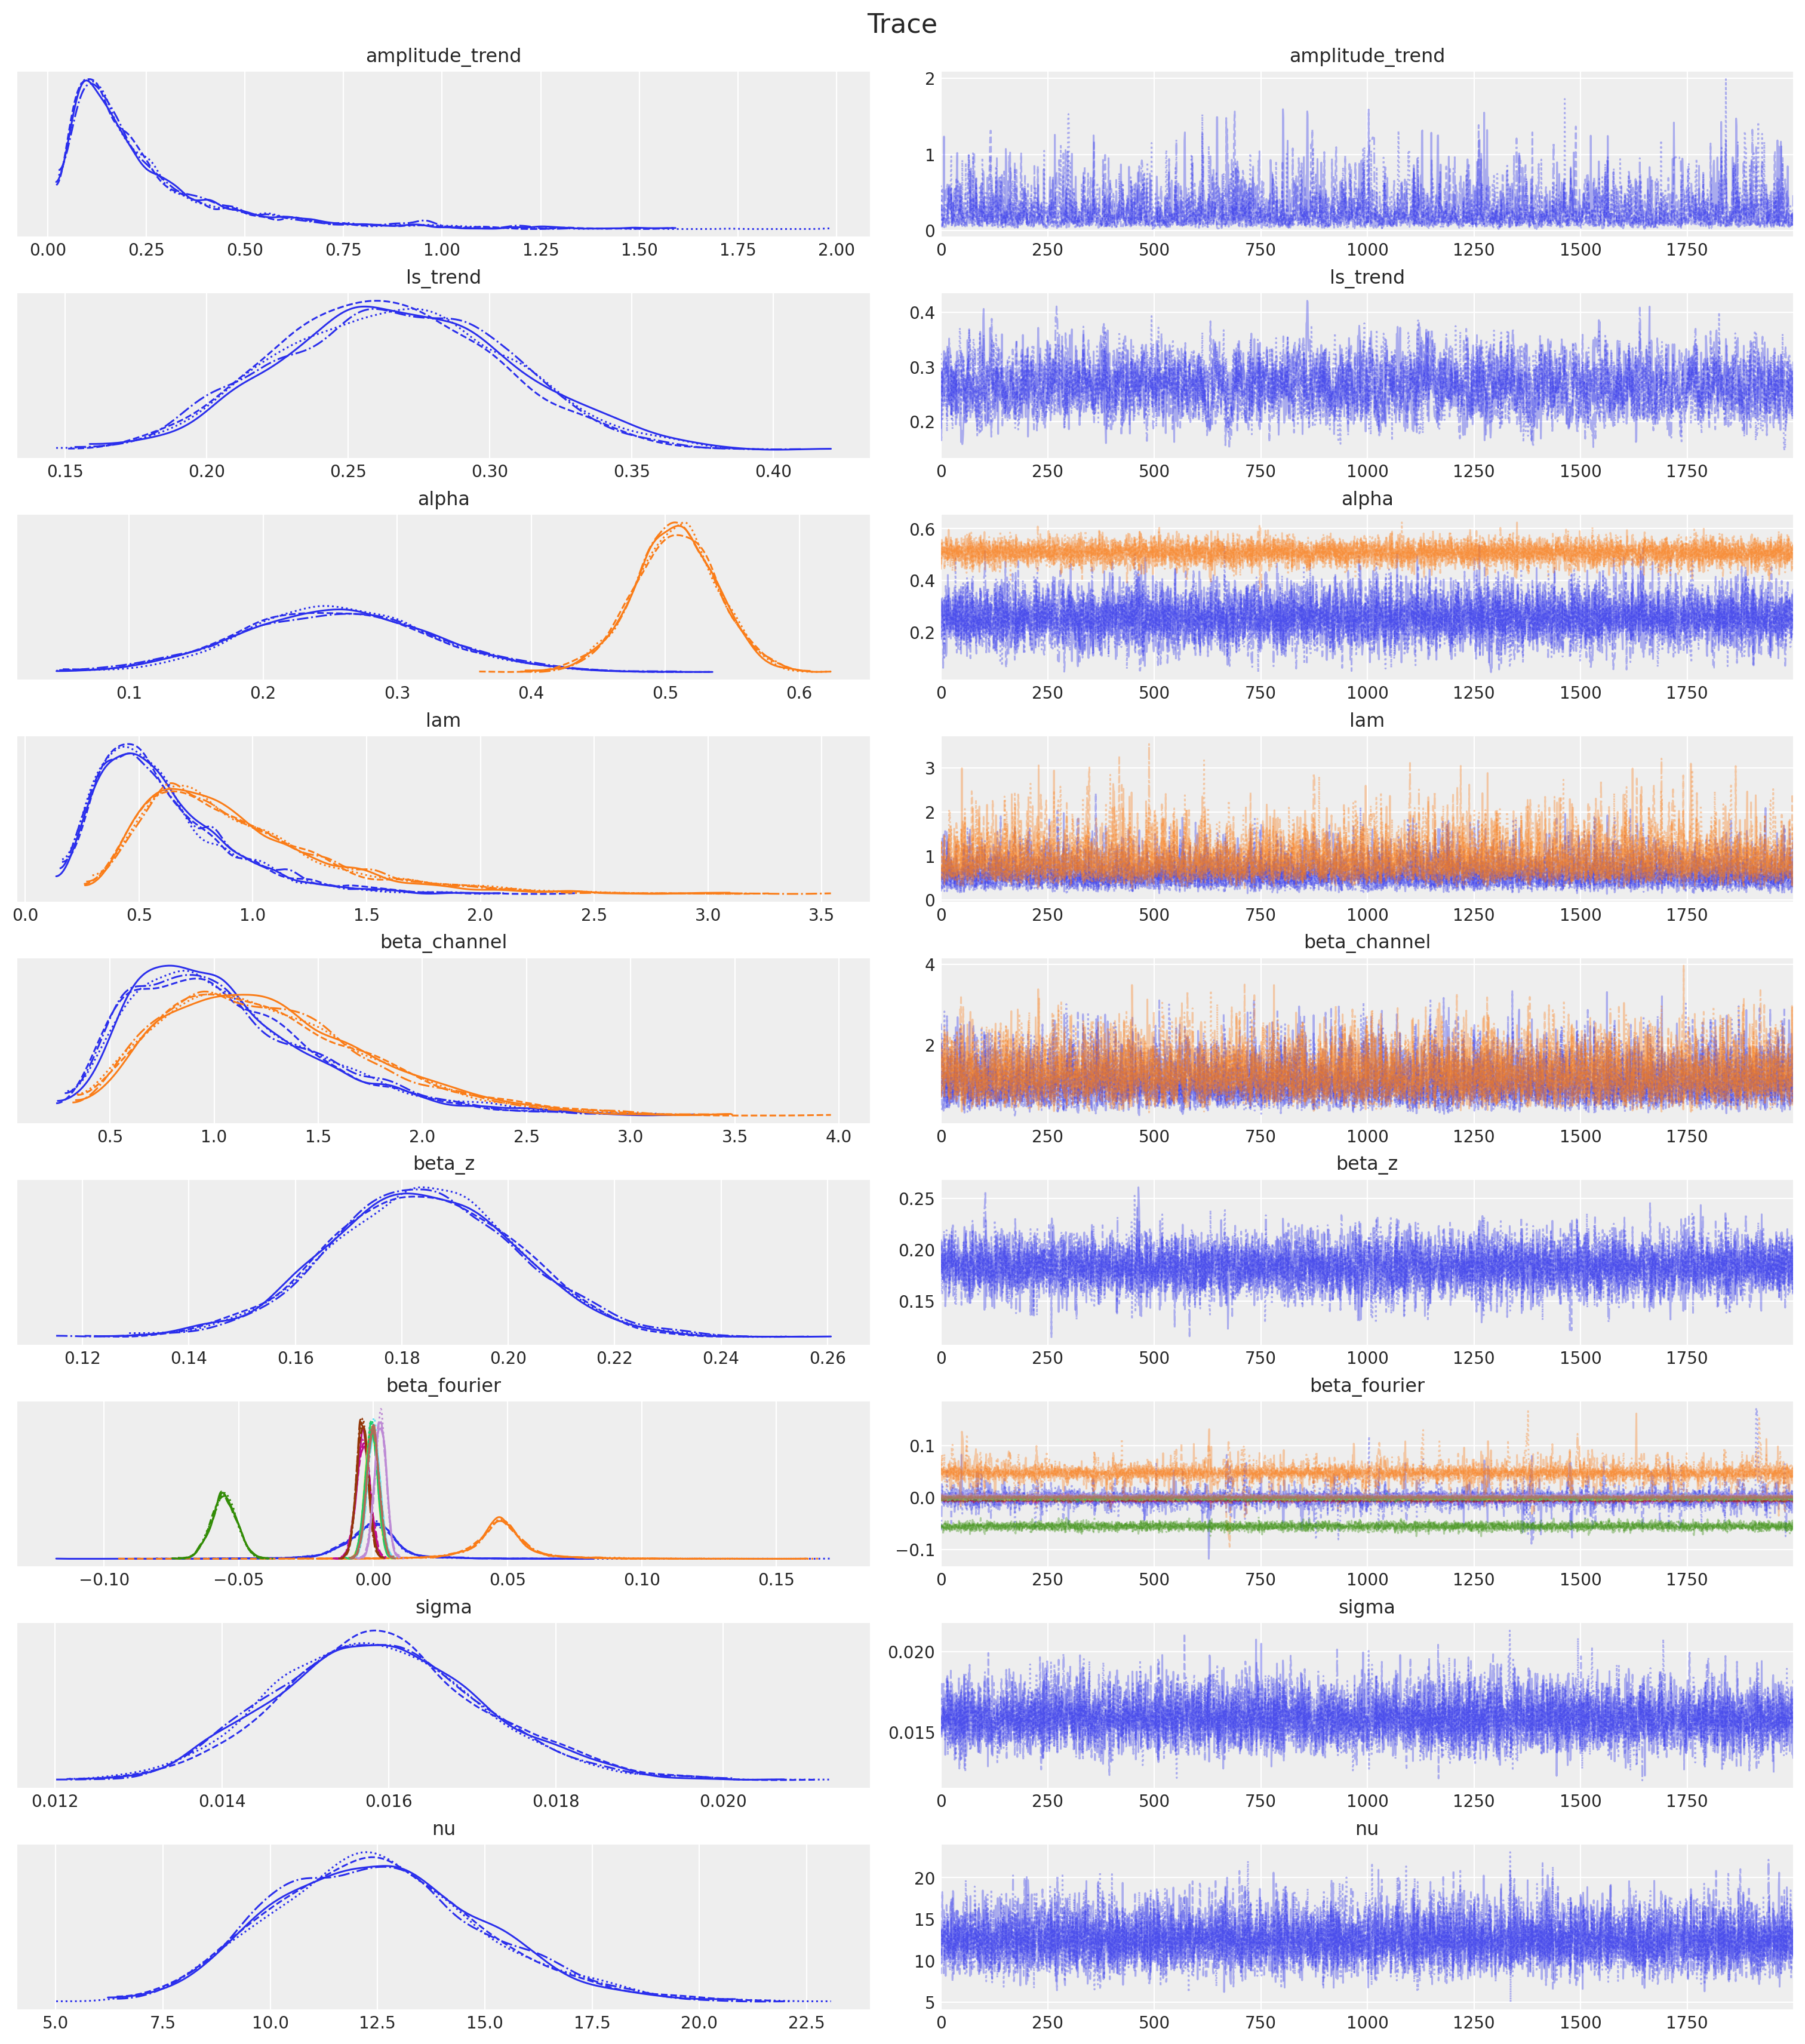

In [67]:
axes = az.plot_trace(
    data=idata_1,
    var_names=var_names,
    compact=True,
    backend_kwargs={"figsize": (15, 17), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16)

In [69]:
pp_vars_original_scale_1 = {
    var_name: xr.apply_ufunc(
        target_scaler.inverse_transform,
        idata_1["posterior"][var_name].expand_dims(dim={"_": 1}, axis=-1),
        input_core_dims=[["date", "_"]],
        output_core_dims=[["date", "_"]],
        vectorize=True,
    ).squeeze(dim="_")
    for var_name in ["mu", "f_trend", "fourier_contribution"]
}

<Axes: xlabel='date', ylabel='y'>

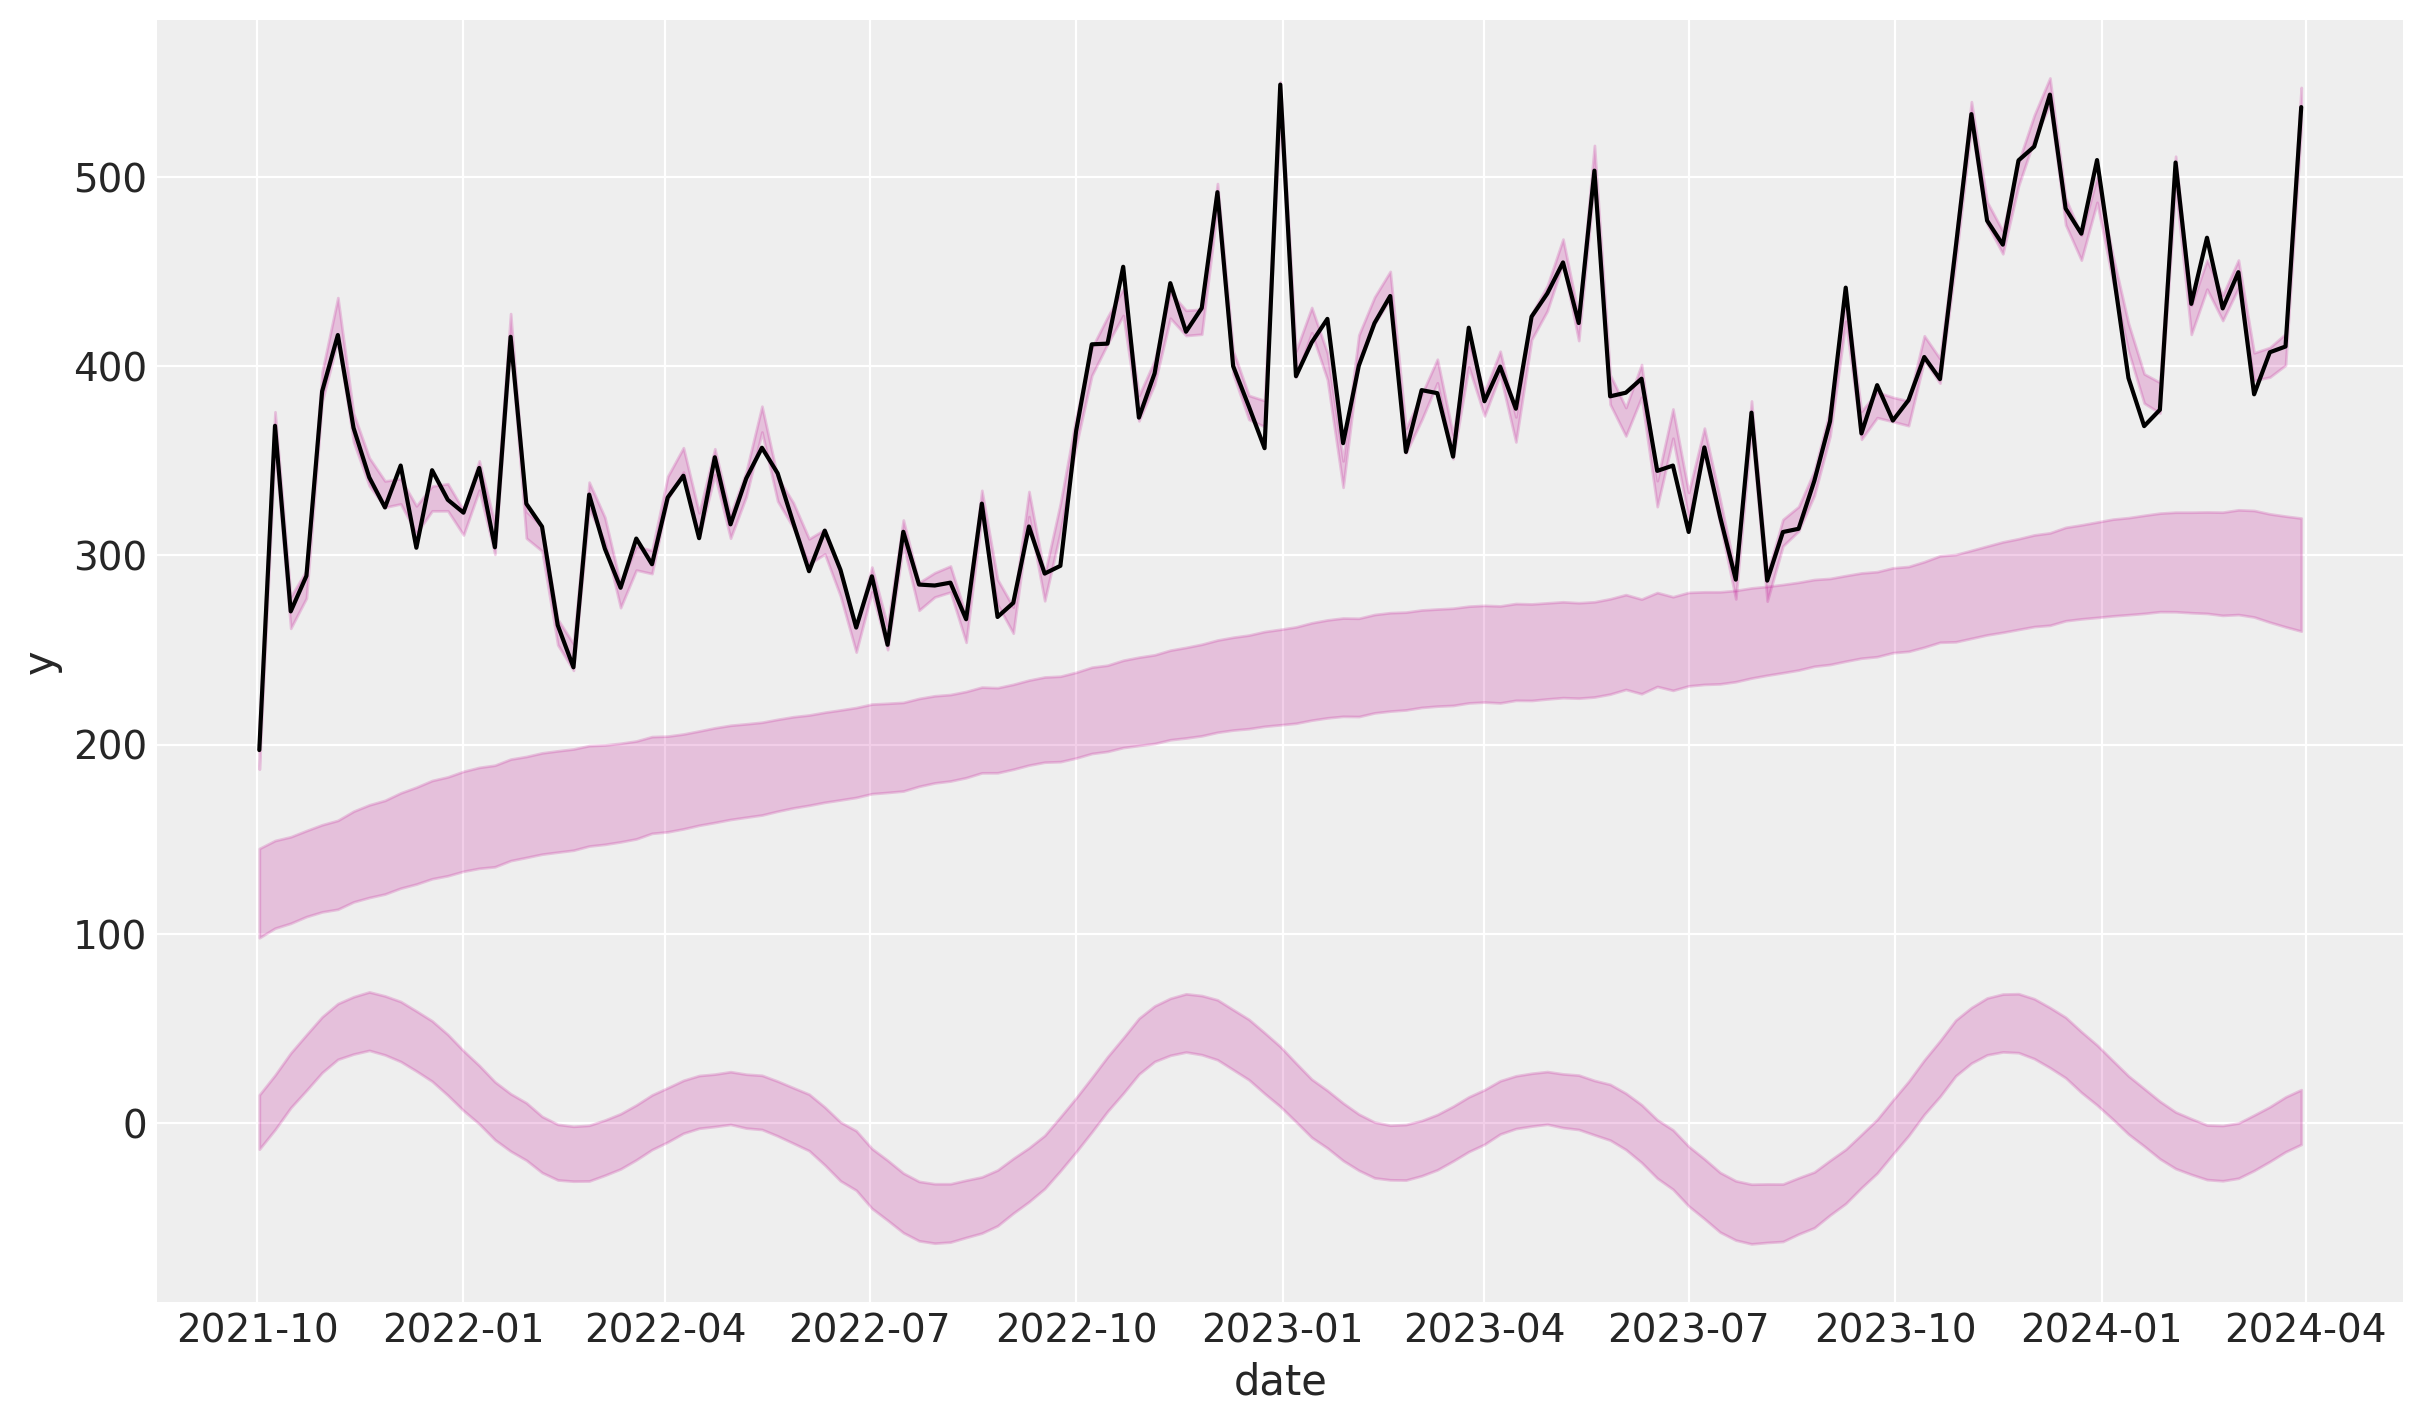

In [74]:
fig, ax = plt.subplots()
sns.lineplot(data=model_df, x="date", y="y", color="black", ax=ax)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["mu"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$f_\text{trend}$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["f_trend"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$f_\text{trend}$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)
az.plot_hdi(
    x=date,
    y=pp_vars_original_scale_1["fourier_contribution"],
    hdi_prob=0.94,
    color="C3",
    fill_kwargs={"alpha": 0.2, "label": r"$f_\text{trend}$ $94\%$ HDI"},
    smooth=False,
    ax=ax,
)